In [37]:
# define the path of the data and project
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [38]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
# convert the profile data to string
ds_cleaned_750['profiler']=ds_cleaned_750['profiler'].astype(str)

In [39]:
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp100grd0001' ... 'itp9grd1097'
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [40]:
# function that plot three histograms, the first is the month distribution, the second and third are the longtidue and latitude distribution
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(ds):
    months = ds.date.dt.month.values

    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
    fig, ax = plt.subplots(1,3,figsize=(20,5),dpi=300)
    sns.histplot(months,ax=ax[0])
    sns.histplot(ds.lon,ax=ax[1])
    sns.histplot(ds.lat,ax=ax[2])
    # set the x and y label
    ax[0].set_xlabel('Month')
    ax[0].set_ylabel('Count')
    ax[1].set_xlabel('Longitude')
    ax[1].set_ylabel('Count')
    ax[2].set_xlabel('Latitude')
    ax[2].set_ylabel('Count')
    # set the title
    ax[0].set_title('Month distribution')
    ax[1].set_title('Longitude distribution')
    ax[2].set_title('Latitude distribution')
    plt.show()

In [41]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

def plot_latlon_bins(ds, lat_step, lon_step):
    # Convert the 'lat' and 'lon' variables into a pandas dataframe
    df_latlon = ds[['lat', 'lon']].to_dataframe()

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    g_len=[]
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            #print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    # print(np.min(g_len))
    # #print the number of groups
    # print(len(g_len))

    g_len_sorted = sorted(g_len)
    # print(g_len_sorted[23])

    # Create a trace for the plot
    trace = go.Scatter(
        x = list(range(len(g_len_sorted))),
        y = g_len_sorted
    )

    # Create the layout for the plot
    layout = go.Layout(
        xaxis=dict(title='Bin No.'),
        yaxis=dict(title='Number of profiles')
    )

    # Create the figure object and plot it
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()


In [42]:
def drop_profiles(ds,lat_step,lon_Step, threshold):
    # Convert the 'lat' and 'lon' variables into a pandas dataframe
    df_latlon = ds[['lat', 'lon']].to_dataframe()

    lat_step = 10.0
    lon_step = 20.0

    lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,185, lon_step))
    lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,95, lat_step))

    latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

    # Create a list to store the groups with sample size larger than the threshold
    latlon_groups_list = []

    # Loop through the groups
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            if len(group) > threshold:
                # latlon_groups_list.append(group_key)
                #print(f"Group {group_key}: {len(group)} rows")
                # randomly select n=threshold samples from the group and get the nprof of it
                group_drop = group.sample(n=len(group)-threshold)
                #print(f"Dropped data: Group {group_key}: {len(group_drop)} rows")
                # replace the group with the group_sample
                latlon_groups_list.append(group_drop)
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    # create a new xarray that contains the data with sample size smaller than the threshold
    ds_spatially_sampled = ds.copy()

    # loop through the latlon_groups_list and create a list to store the nprof of the dropped data
    nprof_dropped = []

    for group in latlon_groups_list:
        # get the nprof of the dropped data
        temp_index = group.index.values
        #print(temp_index)
        nprof_dropped.append(temp_index.tolist())
    
    # reshape the list to 1D
    nprof_dropped = [item for sublist in nprof_dropped for item in sublist]
    # print the nprof_dropped
    #print(nprof_dropped)
    
    # drop the data 
    ds_spatially_sampled = ds_spatially_sampled.drop_sel(nprof=nprof_dropped)
    
    return ds_spatially_sampled


In [43]:
# sample profiles by month
import numpy as np
import xarray as xr

def ramdon_sample_by_month(ds, ratio, random_seed=None):
    if ratio < 0 or ratio > 1:
        raise ValueError("Ratio must be between 0 and 1.")
        
    if 'date' not in ds:
        raise ValueError("Input dataset must have a 'date' variable.")
        
    if 'nprof' not in ds.dims:
        raise ValueError("Input dataset must have a 'nprof' dimension.")
    
    # group the dataset by month
    ds_monthly = ds.groupby('date.month')
    months_with_data = [month for month in ds_monthly.groups.keys() if len(ds_monthly[month]) > 0]
    
    if not months_with_data:
        raise ValueError("Input dataset does not contain any data.")
    
    # find the month with the smallest amount of data
    smallest_month_size = np.min([ds_monthly[month].nprof.size for month in months_with_data])
    selected_size_monthly=ds.nprof.size*ratio/12
    
    if smallest_month_size < selected_size_monthly:
        selected_size_monthly=smallest_month_size
        # ratio=smallest_month_size/ds.nprof.size*12
        print(f"Ratio is too large, selected_size_monthly is reset to the smallest_month_size: {smallest_month_size}")
    

    # print(f"Ratio is {ratio}, {int(selected_size_monthly)} profiles are selected from each month")
    # sample a fixed amount of data from each month
    ds_selected = xr.concat([ds_monthly[month].isel(nprof=np.random.default_rng(random_seed).choice(ds_monthly[month].nprof.size, int(selected_size_monthly), replace=False)) for month in months_with_data], dim='nprof')
    
    ds_selected['nprof'] = np.arange(ds_selected.sizes['nprof'])
    
    return ds_selected


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def plot_heatmap(ds_cleaned, bin_max=None):
    # Define the map bounds and resolution
    lon_min, lon_max = -180, 180
    lat_min, lat_max = 70, 90
    latlon_step = 5
    resolution = 'l'  # l for low resolution, h for high resolution

    # Define bin edges for longitude, latitude, and pressure
    lon_bins = np.arange(lon_min, lon_max+1, latlon_step)
    lat_bins = np.arange(lat_min, lat_max+1, latlon_step)

    # Use the number of profiles in each bin as the height
    H, xedges, yedges = np.histogram2d(ds_cleaned.lon, ds_cleaned.lat, bins=[lon_bins, lat_bins])

    # Set up the figure and the Basemap instance
    fig = plt.figure(figsize=(8,8),dpi=300)
    m = Basemap(projection='npstere', boundinglat=lat_min, lon_0=0, resolution=resolution)

    m.drawparallels(np.arange(lat_min, lat_max+1, 5), labels=[], linewidth=0.1)
    m.drawmeridians(np.arange(lon_min, lon_max+1, 5), labels=[], linewidth=0.1)

    # Create the X and Y grids for the histogram
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    new_col = np.arange(lat_min, lat_max, latlon_step)
    Y = np.concatenate((Y, new_col[:, np.newaxis]), axis=1)

    new_col = lon_max*np.ones(len(lat_bins)-1)
    X = np.concatenate((X, new_col[:, np.newaxis]), axis=1)

    new_row = X[-1]
    X=np.vstack([X,new_row])

    new_row = lat_max*np.ones(np.shape(Y)[1])
    Y=np.vstack([Y,new_row])

    # Create the colored grid using pcolormesh
    cmap = plt.get_cmap('Wistia').copy()
    cmap.set_under(color='white', alpha=1.0)
    cmap.set_over(color='white', alpha=1.0)

    if bin_max is None:
        bin_max = H.max()
    

    m.pcolormesh(X, Y, H.T, cmap=cmap, vmin=1, vmax=bin_max, latlon=True)

    m.drawcoastlines()
    m.fillcontinents(color='grey',lake_color='lightblue')

    # Add a colorbar
    cbar = m.colorbar(location='bottom', pad="5%")
    cbar.set_label('Number of profiles')

    # Set the axis labels and title
    plt.xticks([])
    plt.yticks([])
    plt.title('Profiles distribution')

    # Show the plot
    plt.show()
    print(f'bin max={bin_max}')


In [58]:
from pyxpcm.models import pcm
import plot_toolbox as tb

def GMM(ds_train,ds_fit,K):  
    if np.max(ds_train.pressure) >=0:
        print('Warning, the pressure is not negative!!!')
    pstart=np.max(ds_train.pressure)
    pend=np.min(ds_train.pressure)
    z = np.arange(pstart,pend,-10.)

    pcm_features = {'temperature': z, 'salinity':z}
    m = pcm(K=K, features=pcm_features,maxvar=3)
    
    features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}

    m.fit(ds_train,features=features_in_ds,dim='pressure')
    ds_fit=m.predict(ds_fit,features=features_in_ds,dim='pressure',inplace=True)
    return ds_fit,m

def plot_labels(ds_fit,m):
    tb.plot_pred_map(ds_fit,m)

def plot_mean_profile(ds_fit,m):
    # Calculate the quantile and plot it
    for vname in ['temperature', 'salinity']:
        ds_fit = ds_fit.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)    

    ds_group = ds_fit.groupby('PCM_LABELS')
    tb.plot_quantile(ds_group)


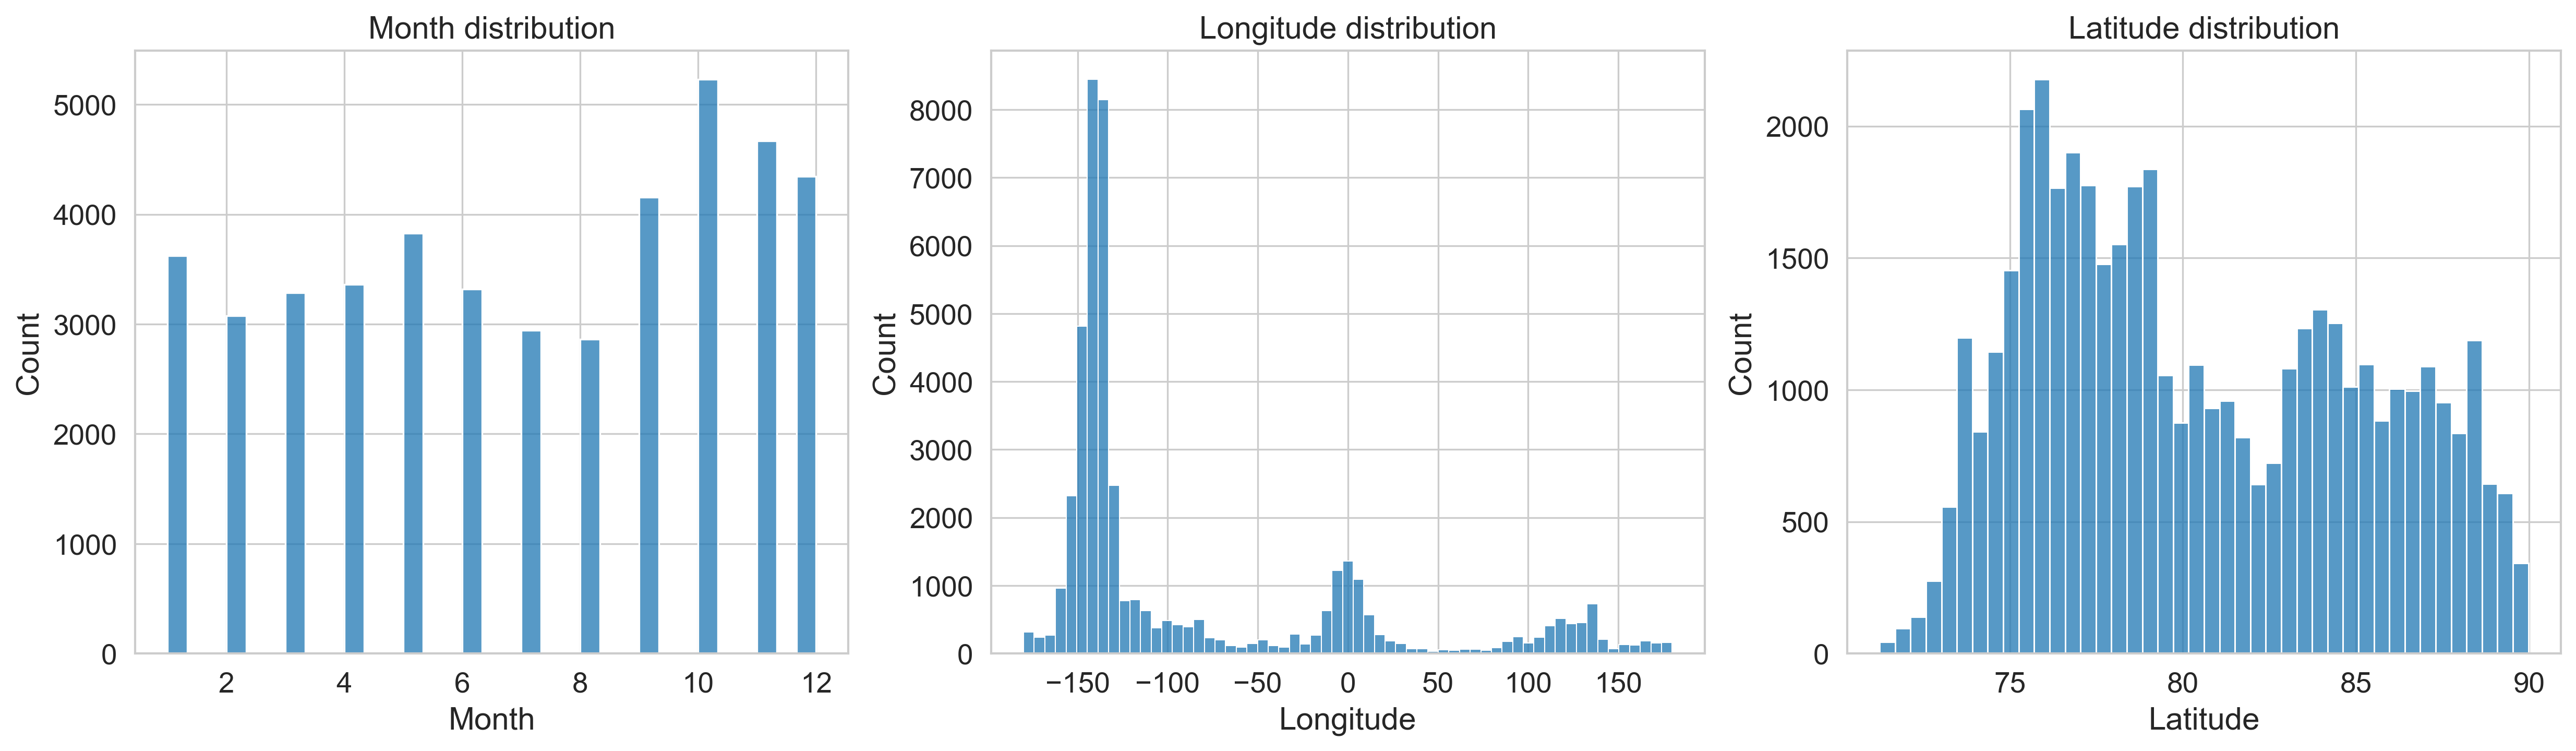

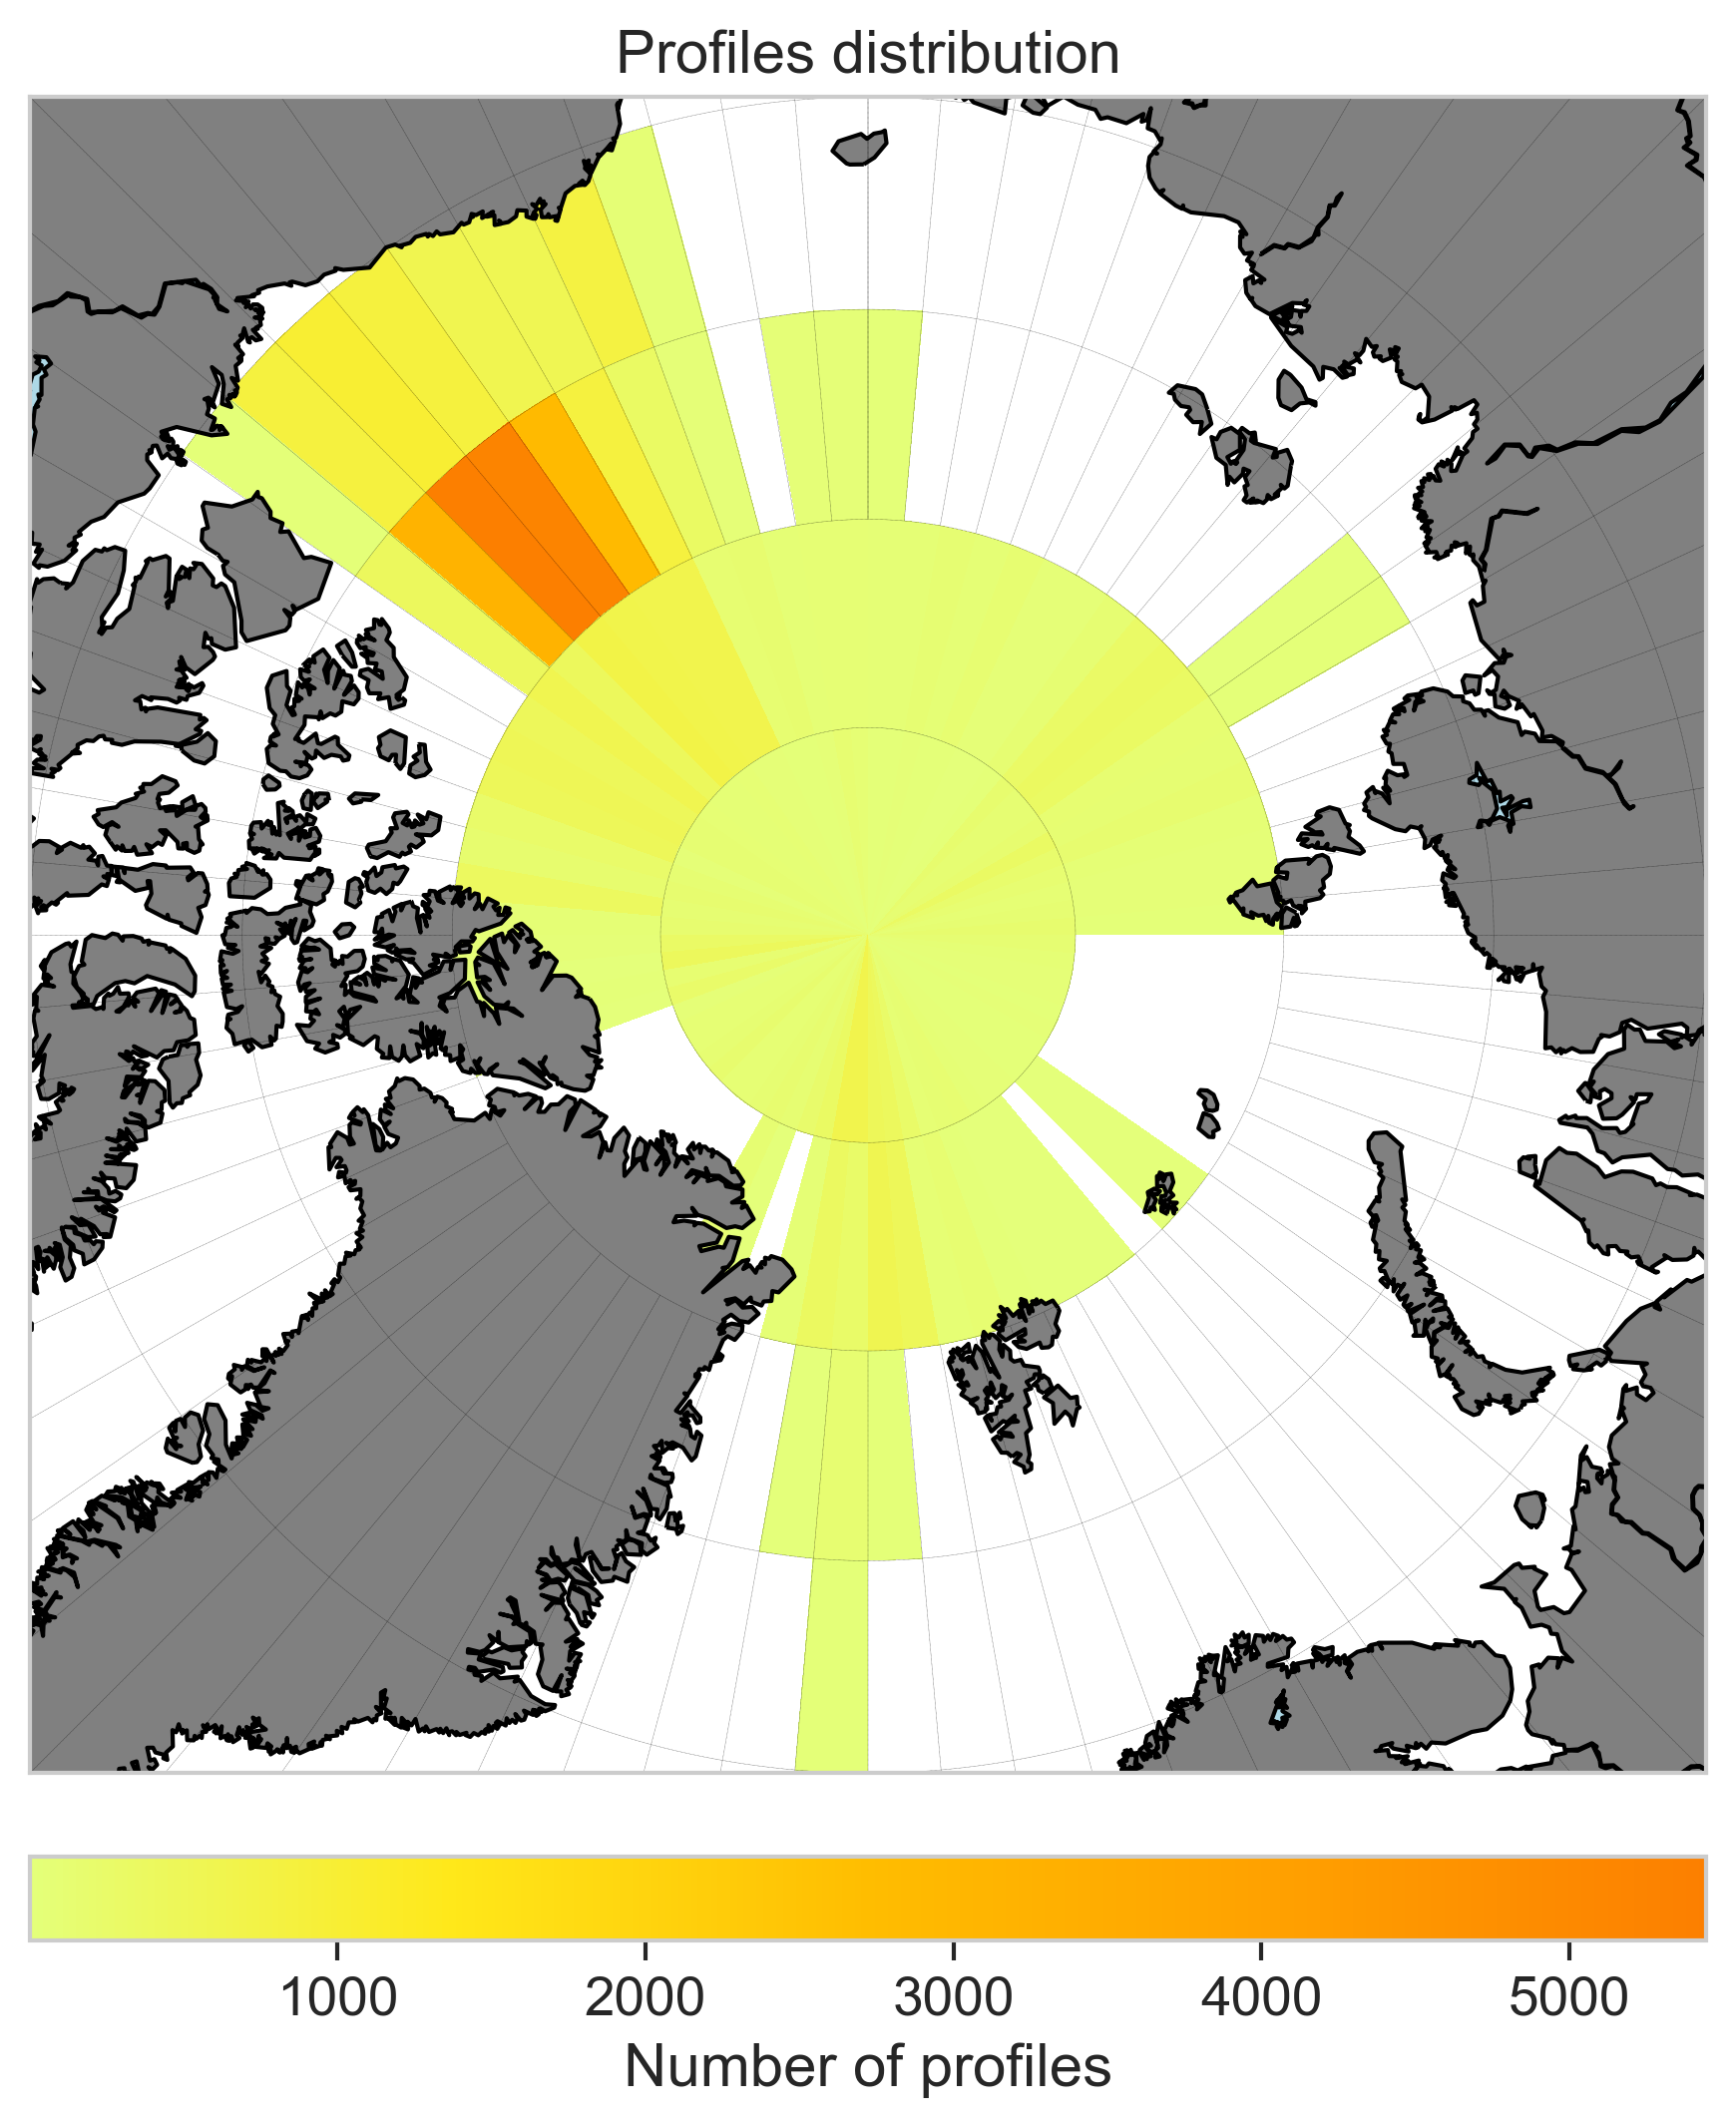

bin max=5444.0


In [46]:
plot_distribution(ds_cleaned_750)
plot_latlon_bins(ds_cleaned_750, 10, 20)
plot_heatmap(ds_cleaned_750)

In [ ]:
ds_cleaned_750_spatially_sampled = drop_profiles(ds_cleaned_750, 10, 20, 2591)

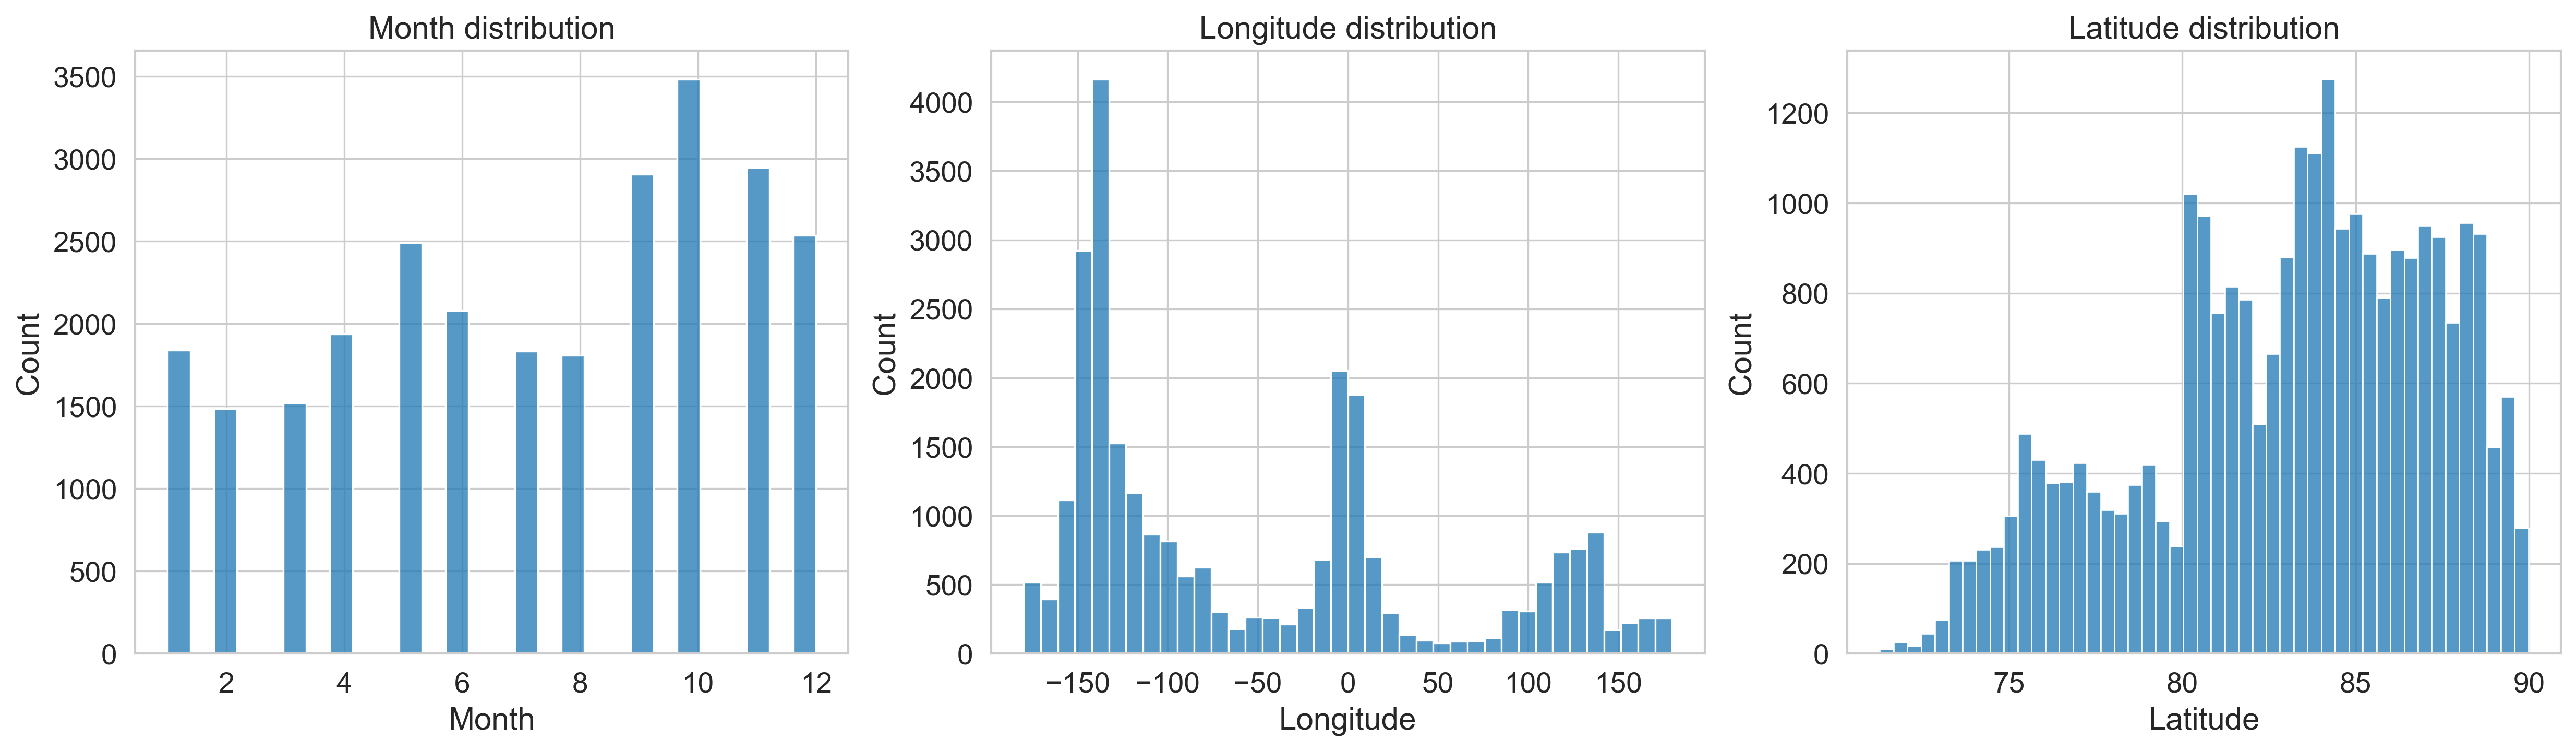

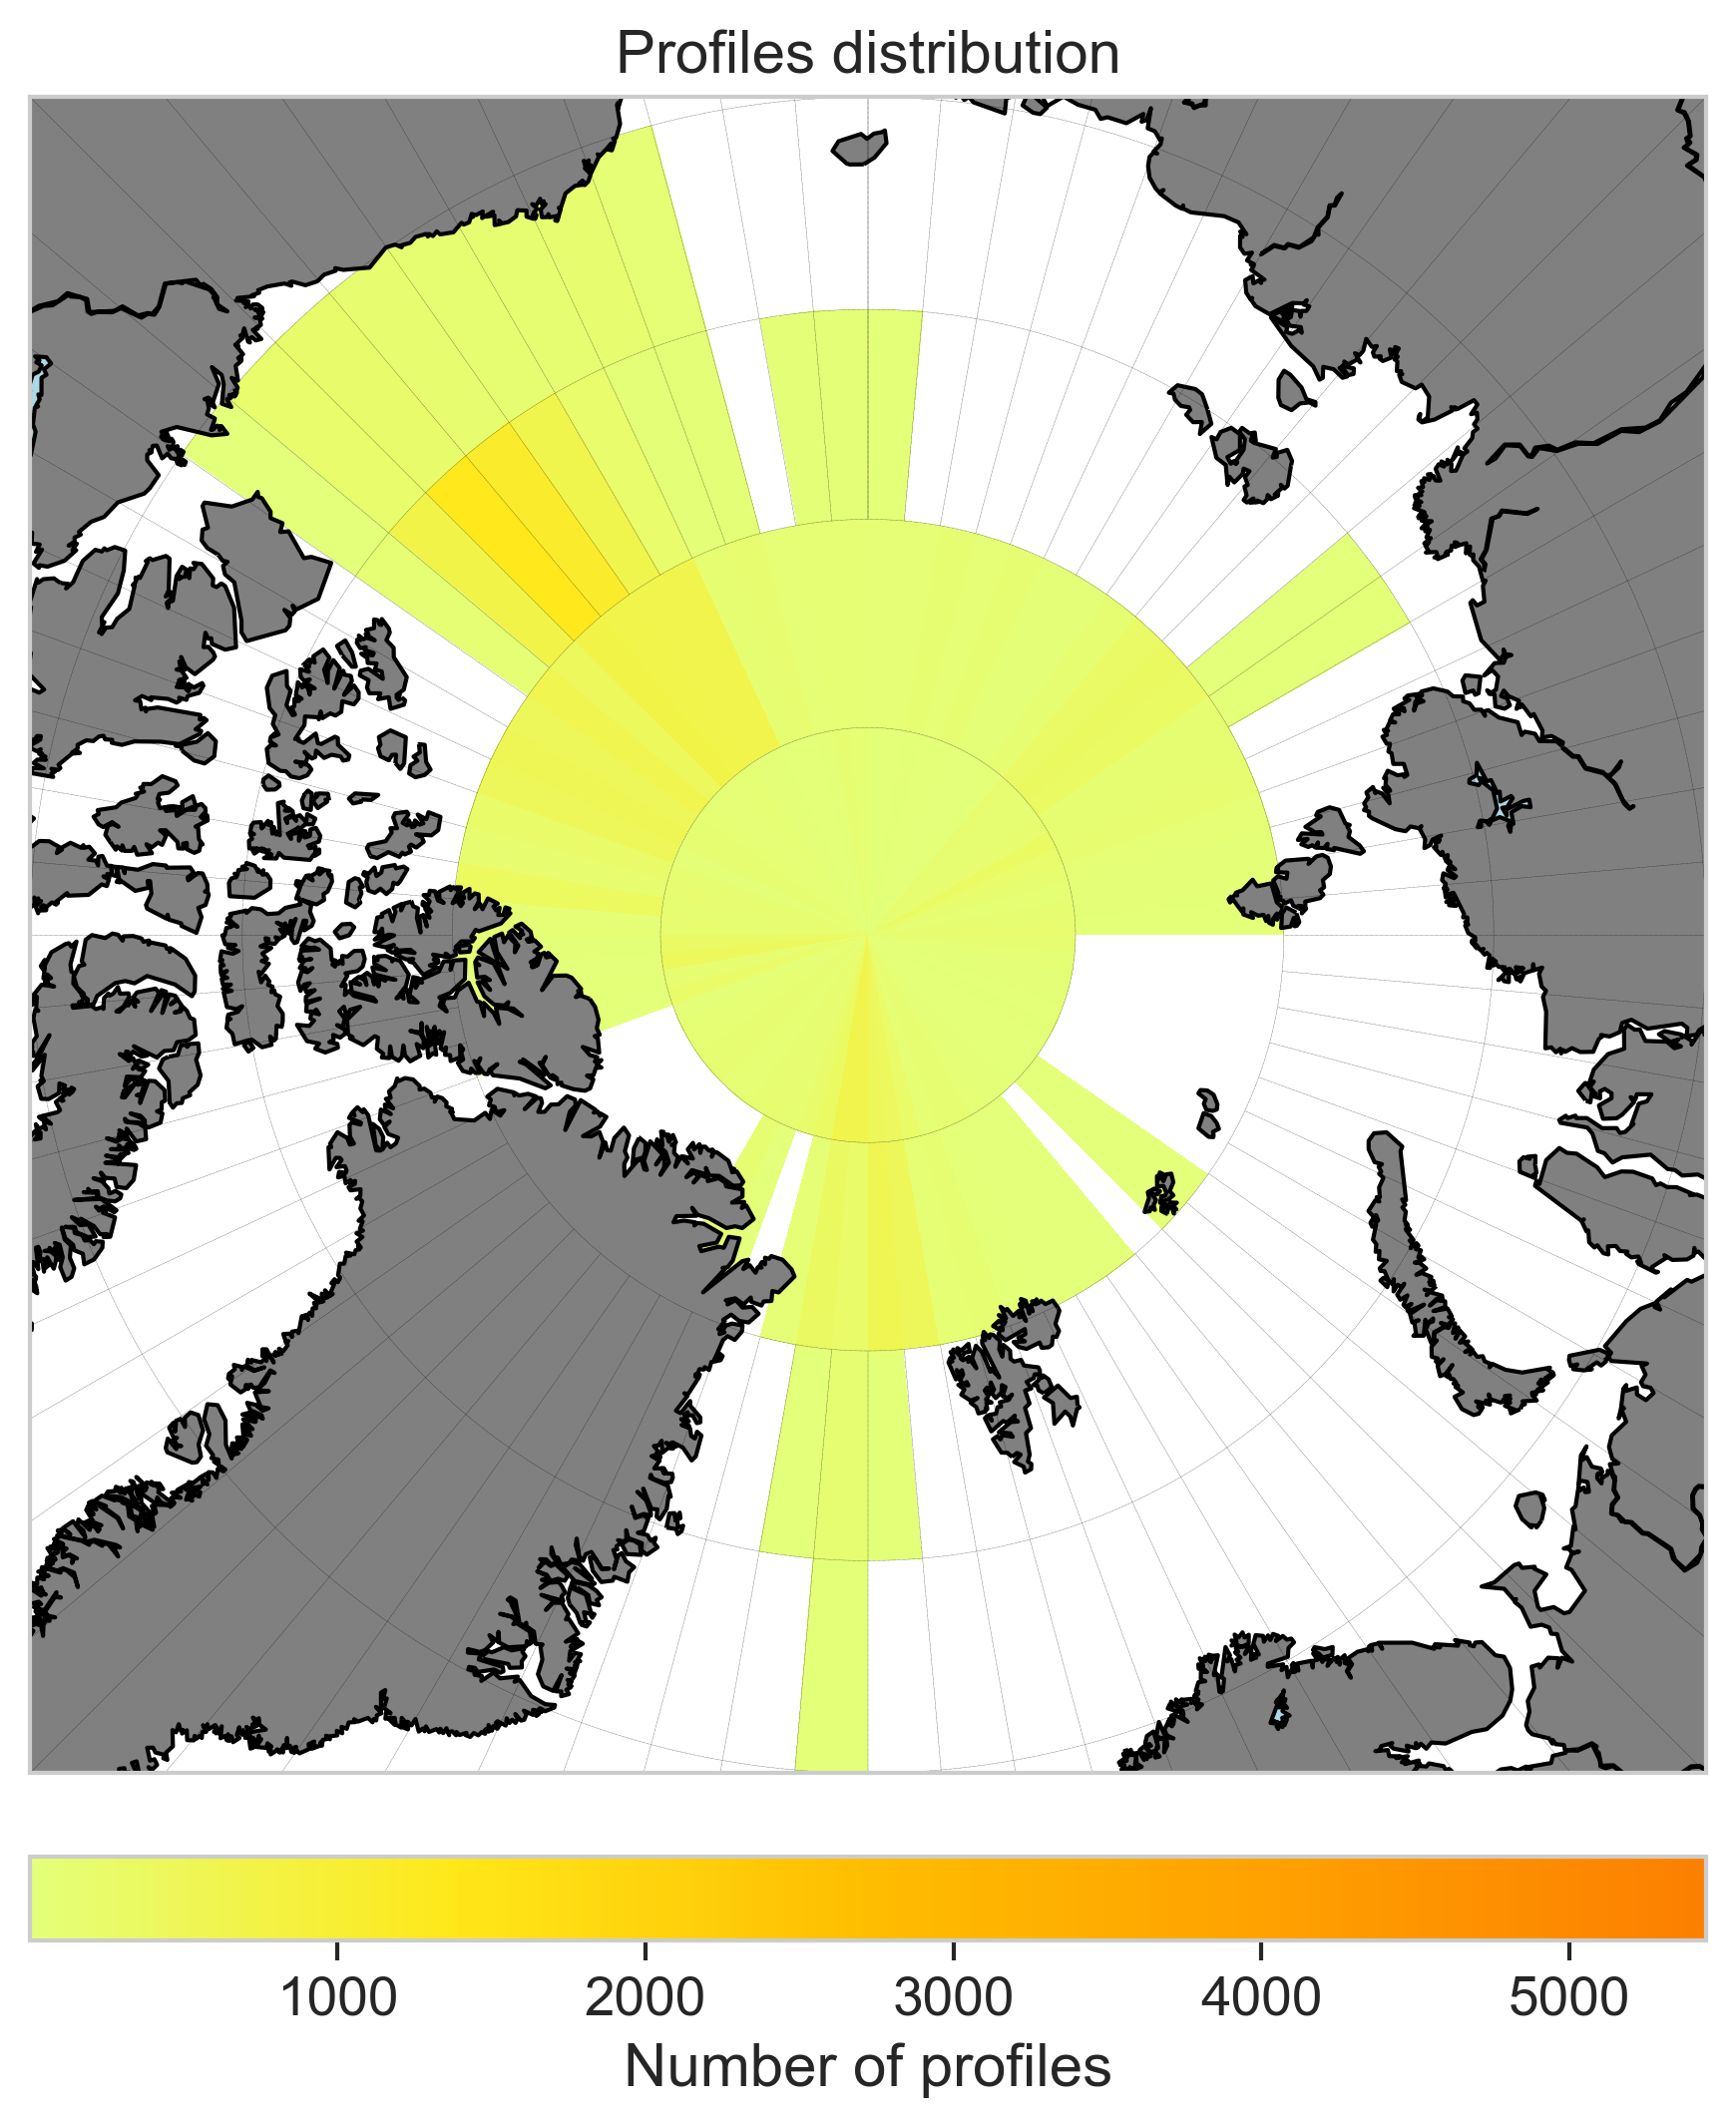

bin max=5444


In [47]:
plot_distribution(ds_cleaned_750_spatially_sampled)
plot_latlon_bins(ds_cleaned_750_spatially_sampled, 10, 20)
plot_heatmap(ds_cleaned_750_spatially_sampled,bin_max=5444)

In [48]:
# sample the data by month
ds_cleaned_750_monthly_sampled = ramdon_sample_by_month(ds_cleaned_750_spatially_sampled, 0.7, random_seed=0)

Ratio is too large, selected_size_monthly is reset to the smallest_month_size: 1484


In [49]:
ds_cleaned_750_monthly_sampled

<xarray.Dataset>
Dimensions:           (nprof: 17808, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp90grd0220' ... 'itp116grd0423'
    date              (nprof) datetime64[ns] 2016-01-10T06:02:02.687999 ... 2...
    lon               (nprof) float64 134.1 -148.5 -143.6 ... -138.1 -84.95
    lat               (nprof) float64 82.05 76.48 76.56 ... 88.55 80.37 88.65
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
  * nprof             (nprof) int32 0 1 2 3 4 ... 17803 17804 17805 17806 17807
Data variables:
    temperature       (nprof, pressure) float64 -1.793 -1.793 ... 0.2814 0.2504
    salinity          (nprof, pressure) float64 32.65 32.65 ... 34.88 34.88
    dissolved_oxygen  (nprof, pressure) float64 nan nan nan nan ... nan nan nan

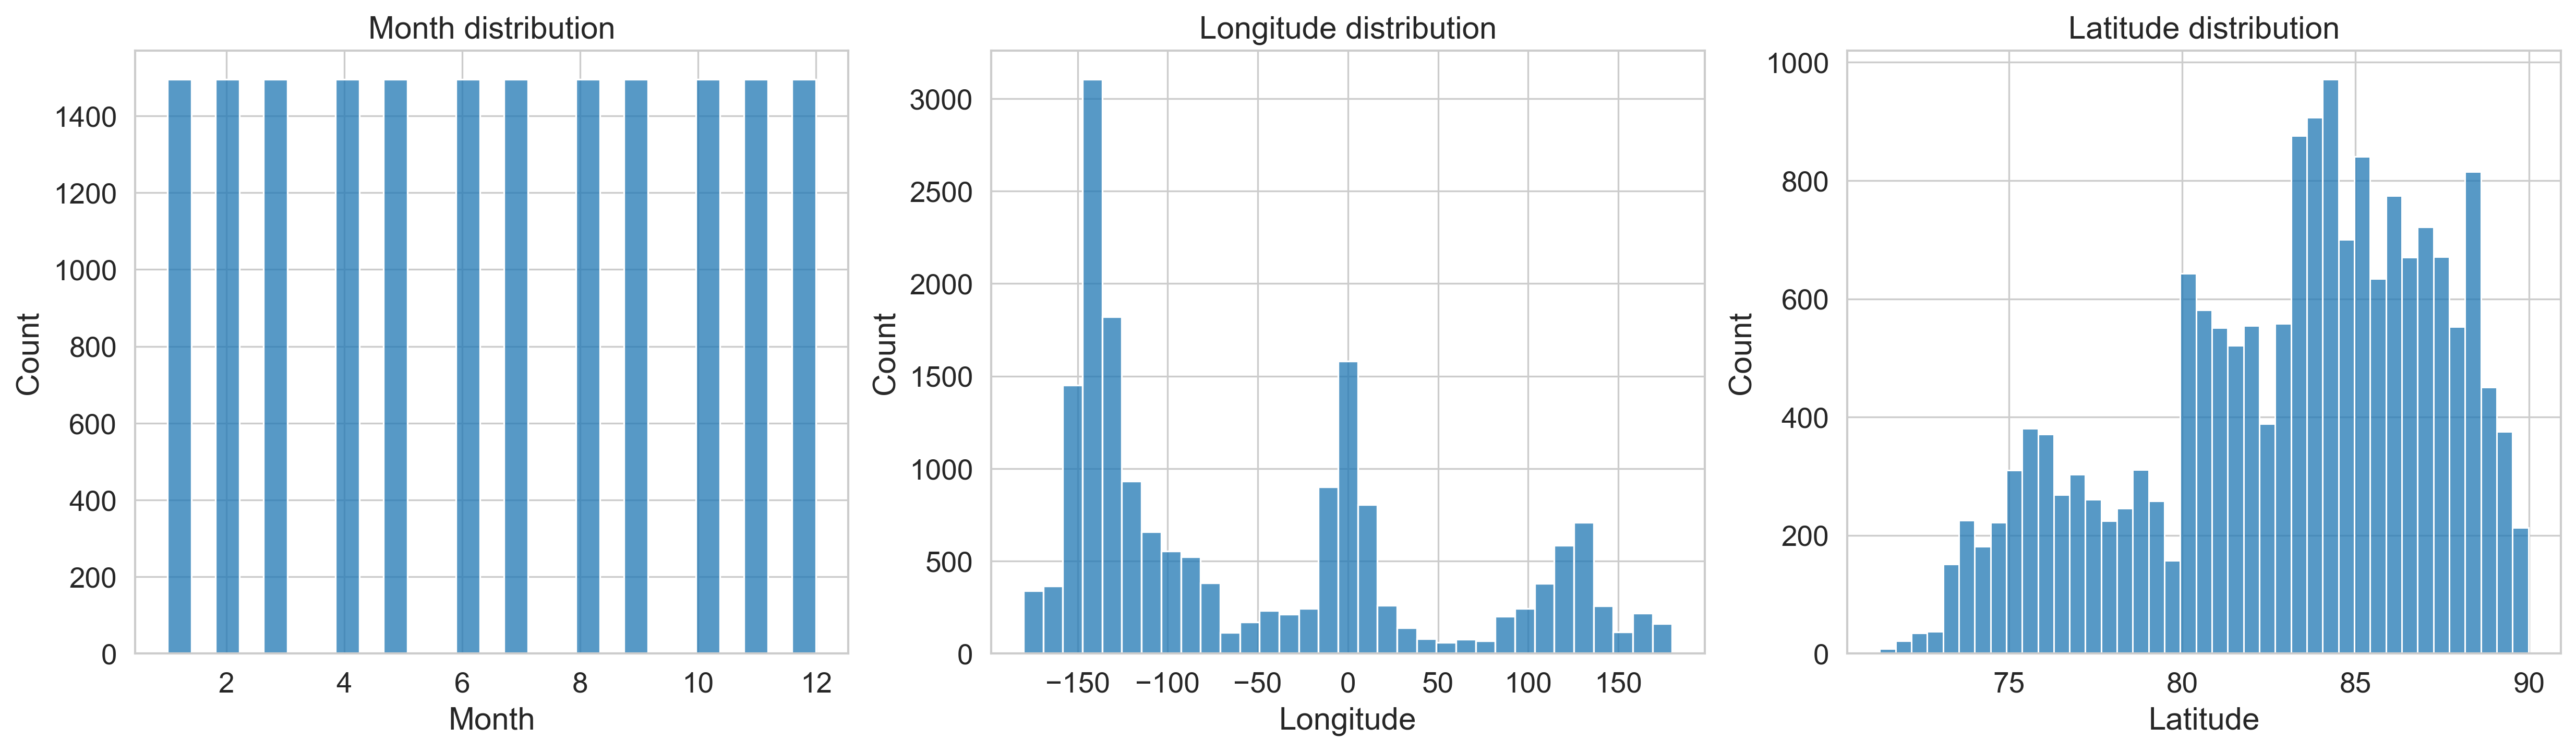

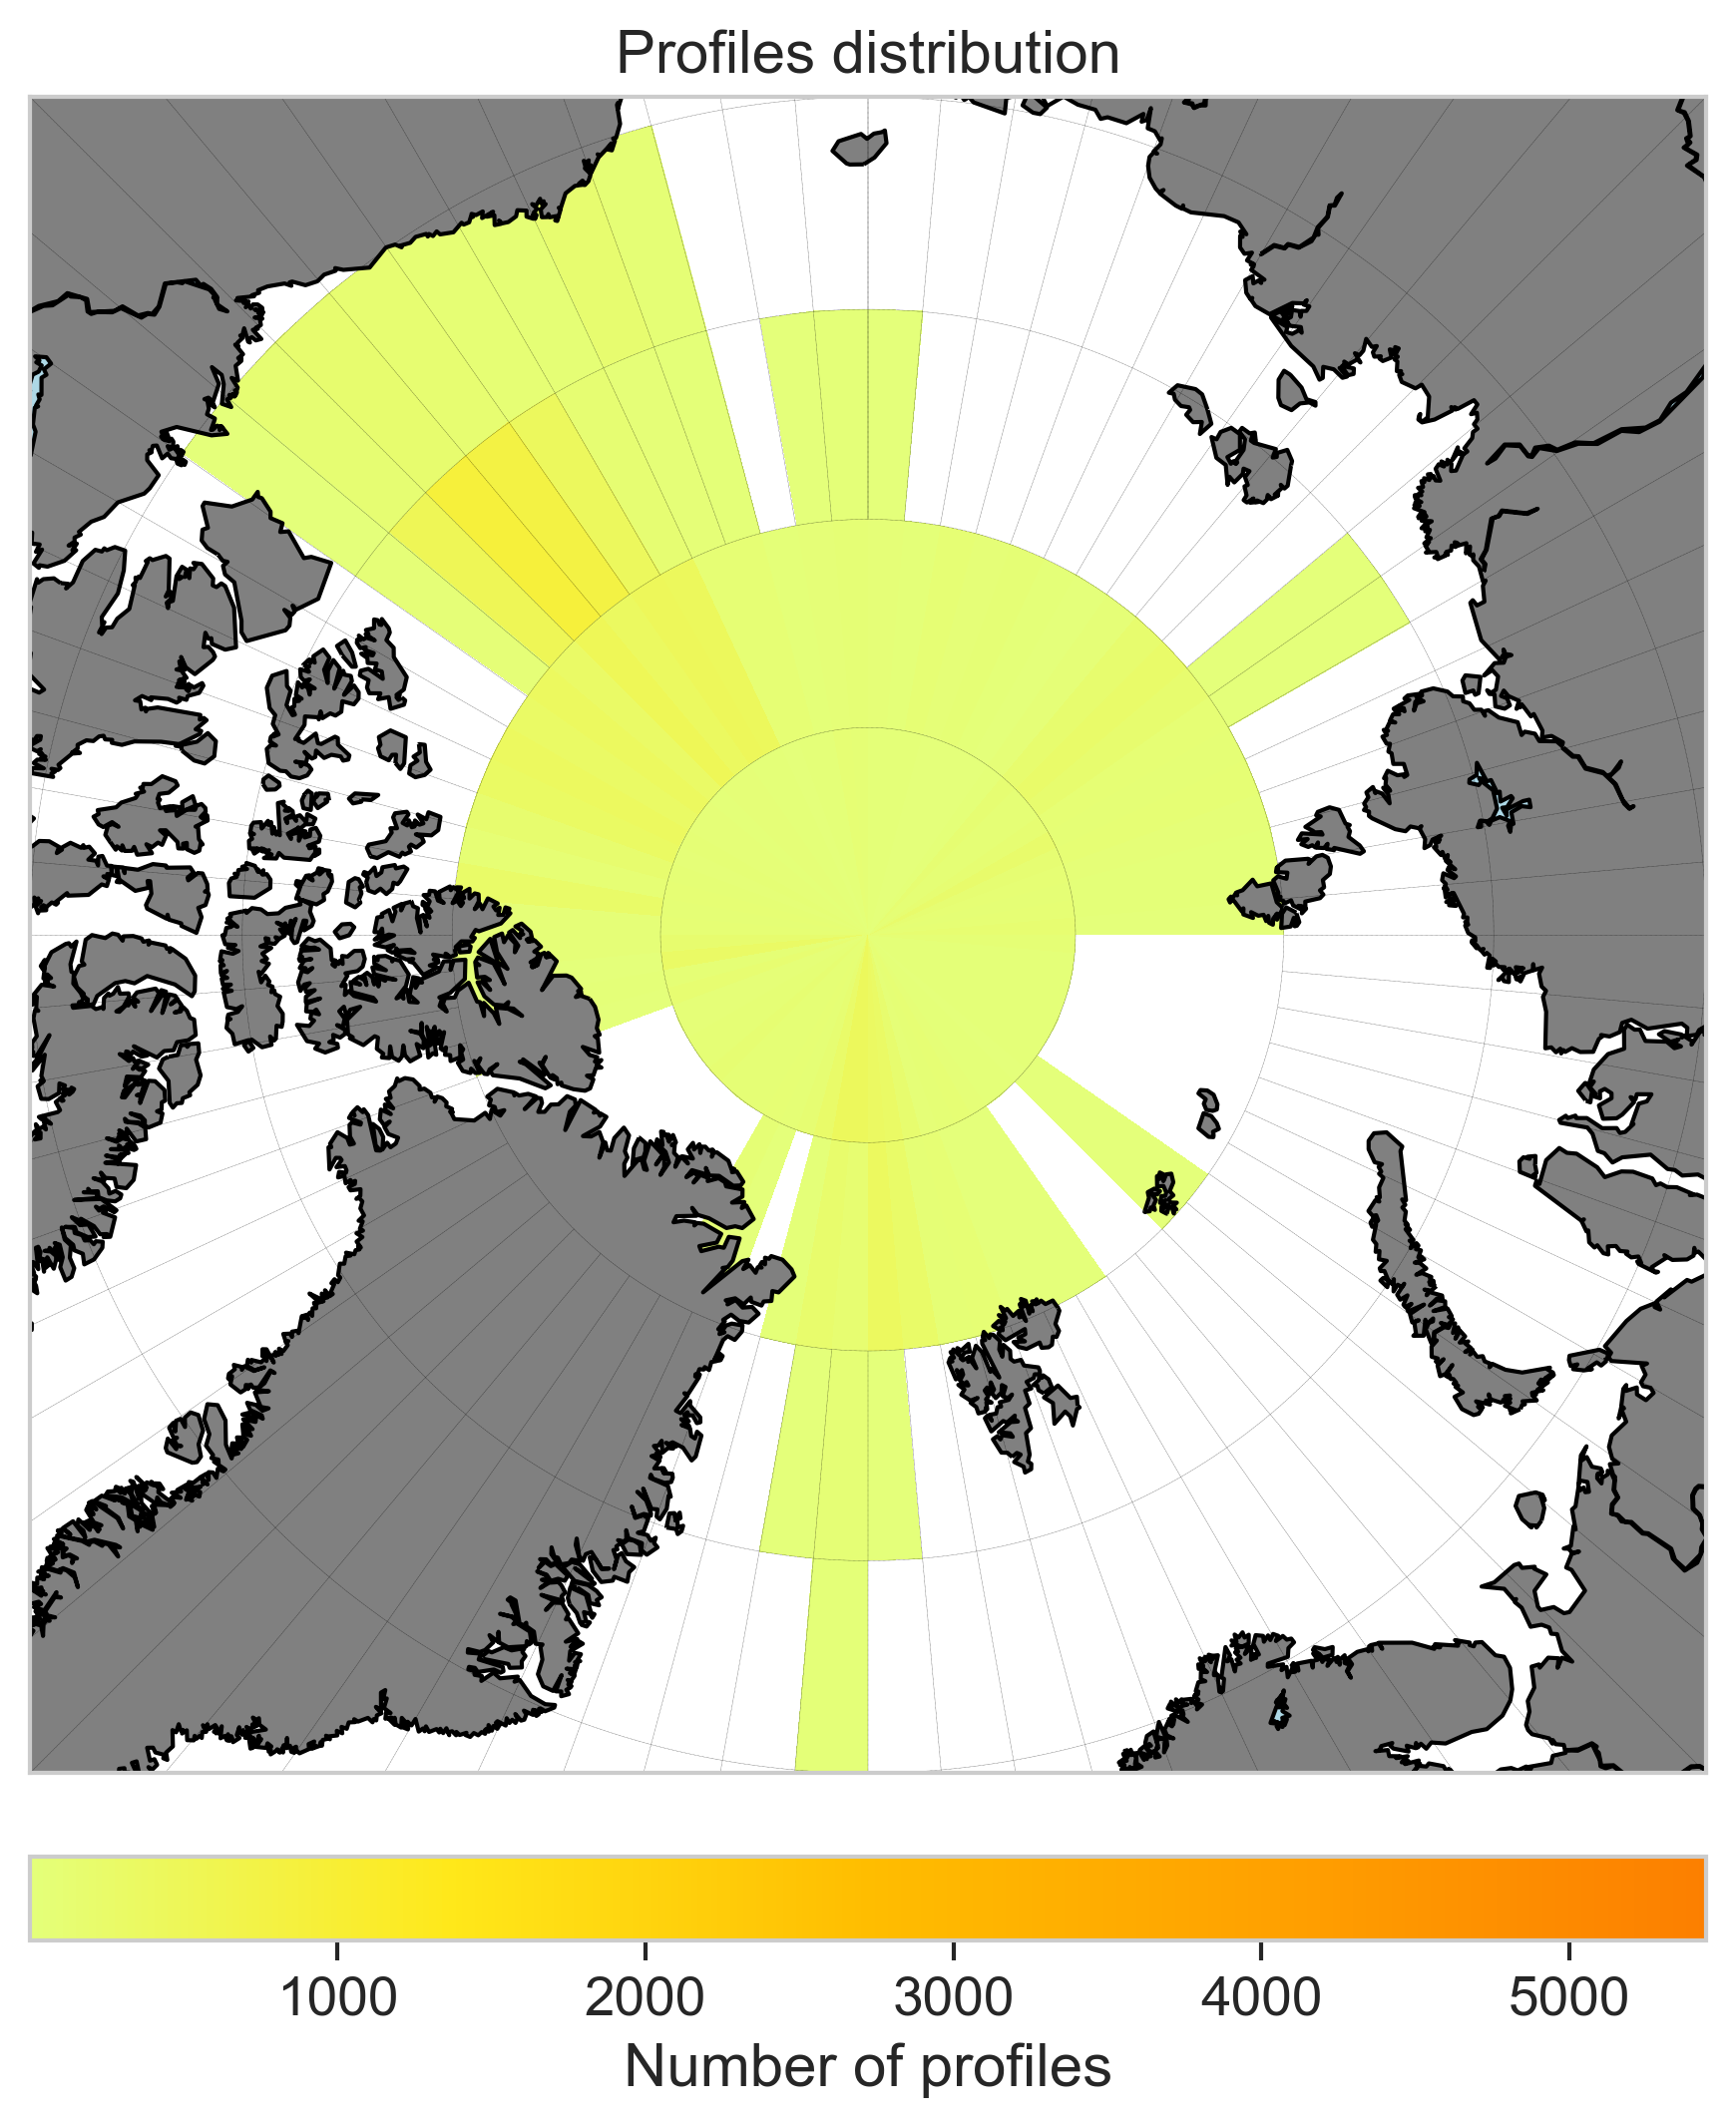

bin max=5444


In [15]:
plot_distribution(ds_cleaned_750_monthly_sampled)
plot_latlon_bins(ds_cleaned_750_monthly_sampled, 10, 20)
plot_heatmap(ds_cleaned_750_monthly_sampled,bin_max=5444)

In [54]:
ds_cleaned_750,m=GMM(ds_cleaned_750_monthly_sampled,ds_cleaned_750,3)

d:\VScode\MRes\pz_venv_w1\lib\site-packages\pyxpcm\xarray.py:89: UserWarning:

PCM_LABELS variable already in the dataset: overwriting



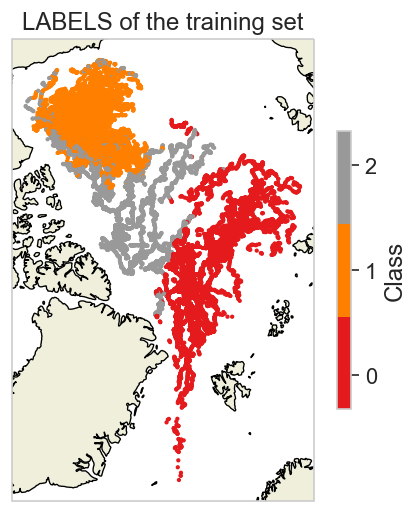

In [55]:
plot_labels(ds_cleaned_750,m)

d:\VScode\MRes\pz_venv_w1\lib\site-packages\pyxpcm\xarray.py:89: UserWarning:

temperature_Q variable already in the dataset: overwriting

d:\VScode\MRes\pz_venv_w1\lib\site-packages\pyxpcm\xarray.py:89: UserWarning:

salinity_Q variable already in the dataset: overwriting



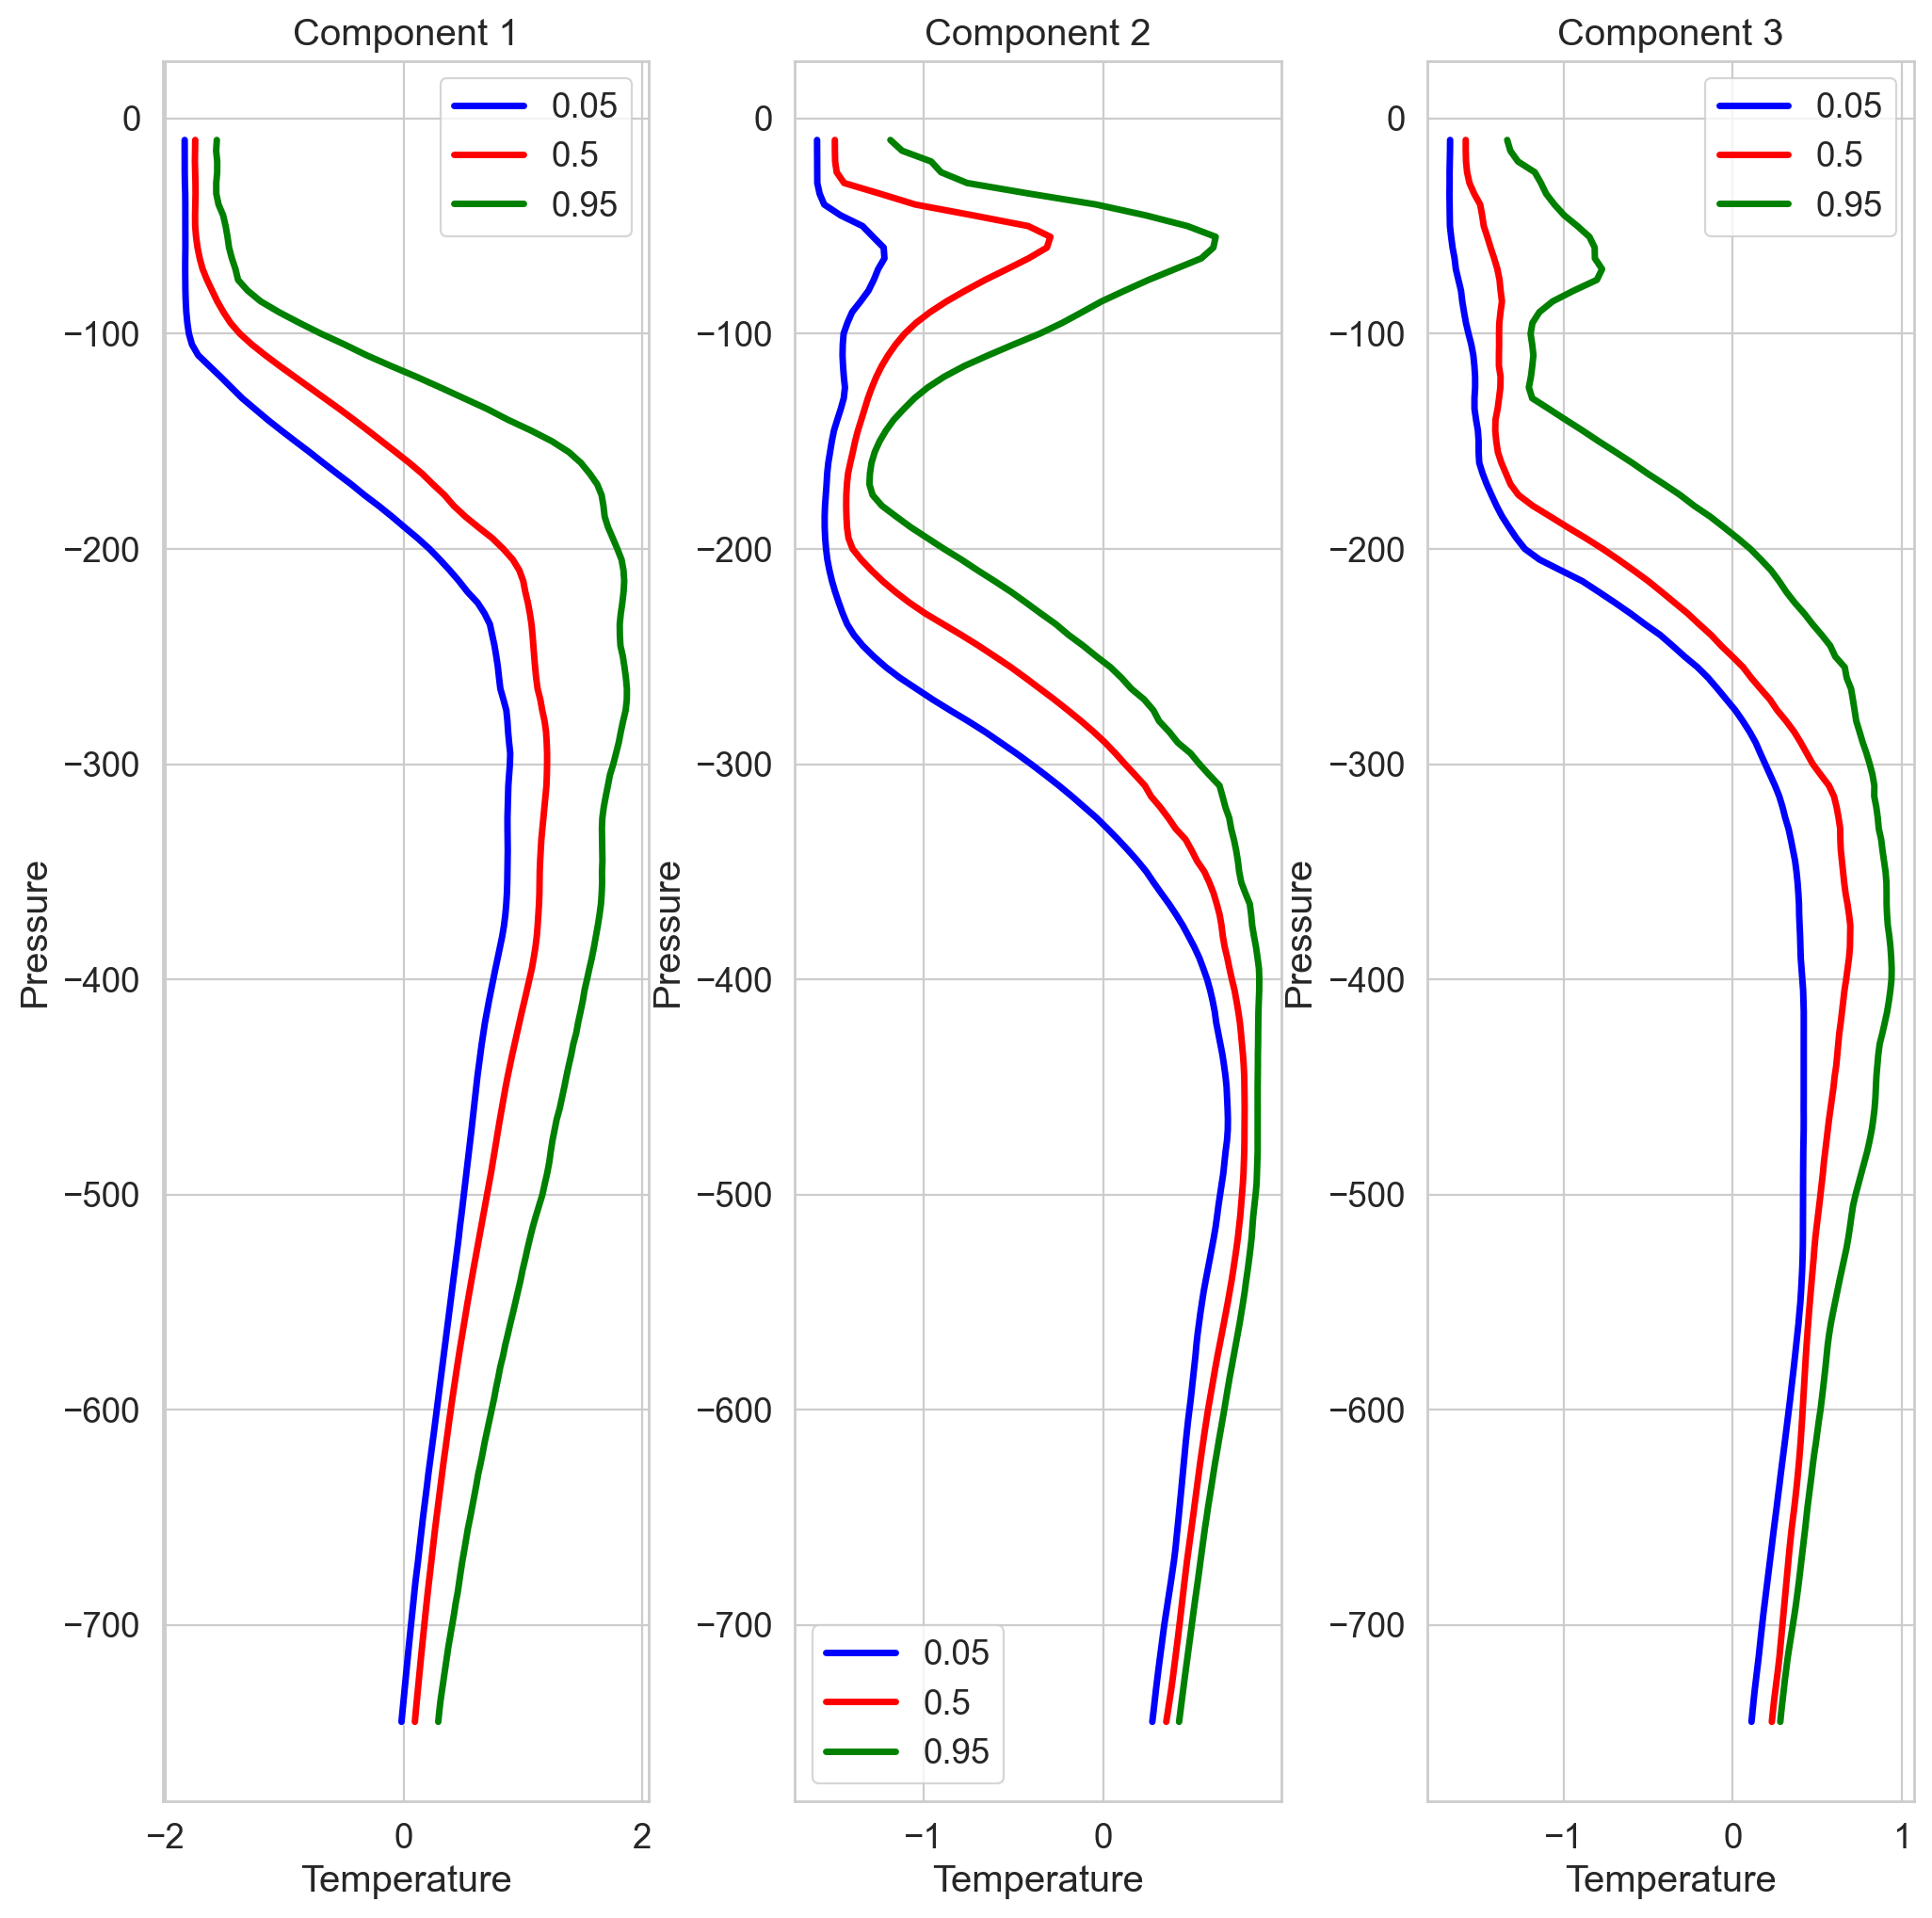

In [56]:
plot_mean_profile(ds_cleaned_750,m)

In [32]:
from pyxpcm.models import pcm
import numpy as np

pstart=np.max(ds_cleaned_750['pressure'])
pend=np.min(ds_cleaned_750['pressure'])

z = np.arange(pstart,pend,-10.)
pcm_features = {'temperature': z, 'salinity':z}

In [33]:
m = pcm(K=3, features=pcm_features)
m

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

In [34]:
features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}
# features_in_ds = ['temperature', 'salinity']
m.fit(ds_cleaned_750,features=features_in_ds,dim='pressure')

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 12.314294

In [35]:
ds_cleaned_750=m.predict(ds_cleaned_750,features=features_in_ds,dim='pressure',inplace=True)

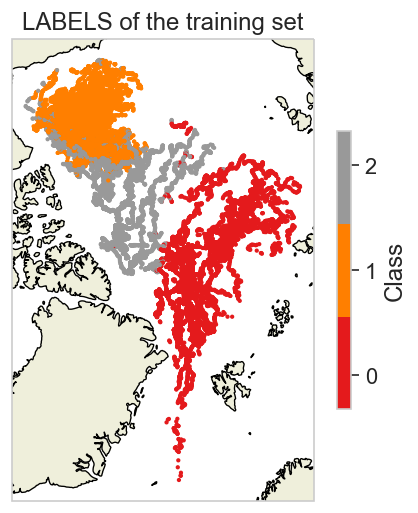

In [36]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

proj = ccrs.NorthPolarStereo()
subplot_kw={'projection': proj, 
            #'extent':([-180,180,60,90],ccrs.PlateCarree())
           }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds_cleaned_750['lon'], ds_cleaned_750['lat'], s=3, c=ds_cleaned_750['PCM_LABELS'], cmap=kmap, transform=ccrs.PlateCarree(), vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

#gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

In [26]:
ds_cleaned=xr.open_dataset(f"{data_path}/ds_cleaned.nc")
ds_cleaned

<xarray.Dataset>
Dimensions:      (nprof: 47890, pressure: 99)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 ...
    salinity     (nprof, pressure) float64 ...

In [27]:
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) object ...
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [31]:
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp100grd0001' ... 'itp9grd1097'
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
  * nprof             (nprof) <U21 '0' '1' '2' '3' ... '44689' '44690' '44691'
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [55]:
import pandas as pd
import numpy as np

# Convert the 'lat' and 'lon' variables into a pandas dataframe
df_latlon = ds_cleaned_750[['lat', 'lon']].to_dataframe()

lat_step = 10.0
lon_step = 20.0

lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,185, lon_step))
lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,95, lat_step))

latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

g_len=[]
for group_key in latlon_groups.groups:
    try:
        group = latlon_groups.get_group(group_key)
        print(f"Group {group_key}: {len(group)} rows")
        g_len.append(len(group))
    except KeyError:
        # Handle the KeyError gracefully
        print(f"No data points for group {group_key}")


# print(np.min(g_len))
# #print the number of groups
# print(len(g_len))


g_len_sorted = sorted(g_len)
# print(g_len_sorted[23])

import plotly.graph_objs as go

# Create a trace for the plot
trace = go.Scatter(
    x = list(range(len(g_len_sorted))),
    y = g_len_sorted
)

# Create the layout for the plot
layout = go.Layout(
    xaxis=dict(title='Bin No.'),
    yaxis=dict(title='Number of profiles')
)

# Create the figure object and plot it
fig = go.Figure(data=[trace], layout=layout)
fig.show()


Group (Interval(-180.0, -160.0, closed='right'), Interval(70.0, 80.0, closed='right')): 244 rows
Group (Interval(-180.0, -160.0, closed='right'), Interval(80.0, 90.0, closed='right')): 746 rows
Group (Interval(-160.0, -140.0, closed='right'), Interval(70.0, 80.0, closed='right')): 12107 rows
Group (Interval(-160.0, -140.0, closed='right'), Interval(80.0, 90.0, closed='right')): 2339 rows
Group (Interval(-140.0, -120.0, closed='right'), Interval(70.0, 80.0, closed='right')): 10920 rows
Group (Interval(-140.0, -120.0, closed='right'), Interval(80.0, 90.0, closed='right')): 2568 rows
Group (Interval(-120.0, -100.0, closed='right'), Interval(80.0, 90.0, closed='right')): 1859 rows
Group (Interval(-100.0, -80.0, closed='right'), Interval(80.0, 90.0, closed='right')): 1564 rows
Group (Interval(-80.0, -60.0, closed='right'), Interval(80.0, 90.0, closed='right')): 594 rows
Group (Interval(-60.0, -40.0, closed='right'), Interval(80.0, 90.0, closed='right')): 498 rows
Group (Interval(-40.0, -20.

In [10]:
df_latlon

lat       lon       profiler                       date
nprof                                                             
0      80.0378 -149.1544  itp100grd0001 2017-09-20 00:02:04.416000
1      80.0992 -148.7704  itp100grd0003 2017-09-21 00:02:02.688000
2      80.1768 -147.9601  itp100grd0005 2017-09-22 00:02:02.688000
3      80.2801 -145.6491  itp100grd0009 2017-09-24 00:02:02.688000
4      80.3072 -145.0618  itp100grd0011 2017-09-25 00:02:02.688000
...        ...       ...            ...                        ...
44687  82.7761  -97.1397    itp9grd1009 2008-12-04 00:24:16.704000
44688  82.7275  -97.1654    itp9grd1012 2008-12-04 12:00:05.183999
44689  82.6869  -97.2736    itp9grd1013 2008-12-05 00:24:14.976000
44690  82.6484  -97.4092    itp9grd1016 2008-12-05 12:00:05.183999
44691  82.7462  -95.5062    itp9grd1097 2009-01-15 00:24:18.432000

[44692 rows x 4 columns]

In [5]:
min_bin_sample_size=np.min(g_len)
min_bin_sample_size

26

10920


In [19]:
df_latlon_sampled

NameError: name 'df_latlon_sampled' is not defined

In [54]:
# loop through the latlon_groups and get the groups with sample size larger than the threshold=2591
threshold = 2591


# Create a list to store the groups with sample size larger than the threshold
latlon_groups_list = []

# Loop through the groups
for group_key in latlon_groups.groups:
    try:
        group = latlon_groups.get_group(group_key)
        if len(group) > threshold:
            # latlon_groups_list.append(group_key)
            print(f"Group {group_key}: {len(group)} rows")
            # randomly select n=threshold samples from the group and get the nprof of it
            group_drop = group.sample(n=len(group)-threshold)
            print(f"Dropped data: Group {group_key}: {len(group_drop)} rows")
            # replace the group with the group_sample
            latlon_groups_list.append(group_drop)
    except KeyError:
        # Handle the KeyError gracefully
        print(f"No data points for group {group_key}")

# create a new xarray that contains the data with sample size smaller than the threshold
ds_cleaned_750_spatially_sampled = ds_cleaned_750.copy()

# loop through the latlon_groups_list and create a list to store the nprof of the dropped data
nprof_dropped = []

for group in latlon_groups_list:
    # get the nprof of the dropped data
    temp_index=group.index.values
    print(temp_index)
    nprof_dropped.append(temp_index.tolist())
# reshape the list to 1D
nprof_dropped = [item for sublist in nprof_dropped for item in sublist]
# print the nprof_dropped
print (nprof_dropped)
# drop the data 
ds_cleaned_750_spatially_sampled = ds_cleaned_750_spatially_sampled.drop_sel(nprof=nprof_dropped)

ds_cleaned_750_spatially_sampled

Group (Interval(-160.0, -140.0, closed='right'), Interval(70.0, 80.0, closed='right')): 12107 rows
Dropped data: Group (Interval(-160.0, -140.0, closed='right'), Interval(70.0, 80.0, closed='right')): 9516 rows
Group (Interval(-140.0, -120.0, closed='right'), Interval(70.0, 80.0, closed='right')): 10920 rows
Dropped data: Group (Interval(-140.0, -120.0, closed='right'), Interval(70.0, 80.0, closed='right')): 8329 rows
[21934 33813  3632 ... 32563 39292 27184]
[31936 11552 33386 ...  2659 41302  5396]
[21934, 33813, 3632, 39739, 20372, 26732, 34010, 8150, 36465, 6434, 23876, 40688, 39645, 38888, 6709, 30224, 27520, 39259, 40865, 33829, 23347, 6624, 31806, 43315, 31959, 35612, 13320, 27461, 13413, 33953, 11765, 30230, 30405, 3364, 40072, 40512, 19313, 1898, 6548, 19455, 36329, 6689, 23353, 12667, 36962, 36321, 38868, 38802, 40652, 30052, 34041, 6487, 1703, 27651, 6781, 33456, 23652, 30500, 41732, 11767, 3341, 1962, 33998, 33307, 40135, 27638, 19913, 6915, 32579, 40802, 32962, 24514, 3283

<xarray.Dataset>
Dimensions:           (nprof: 26847, pressure: 148)
Coordinates:
    profiler          (nprof) object 'itp100grd0001' ... 'itp9grd1097'
    date              (nprof) datetime64[ns] 2017-09-20T00:02:04.416000 ... 2...
    lon               (nprof) float64 -149.2 -148.8 -148.0 ... -97.41 -95.51
    lat               (nprof) float64 80.04 80.1 80.18 ... 82.69 82.65 82.75
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [22]:
latlon_groups_list[0]

lat       lon       profiler                       date
nprof                                                             
40848  75.9657 -151.0846   itp89grd0401 2016-04-22 00:02:04.416000
6508   75.0030 -148.1163  itp120grd0628 2021-02-27 18:02:07.872000
40154  78.1087 -141.0512   itp87grd0308 2015-01-30 06:02:01.824000
12859  78.7547 -141.8952    itp1grd0221 2005-10-11 06:00:02.591999
19416  75.2948 -152.2984   itp33grd0445 2010-05-18 00:00:06.047999
...        ...       ...            ...                        ...
6906   76.8055 -144.4767  itp120grd1061 2021-06-16 00:02:09.600000
12918  79.1835 -142.2409    itp1grd0295 2005-10-29 18:00:02.592000
33980  75.2906 -152.9640   itp70grd2691 2014-04-18 00:02:01.824000
24717  76.3386 -146.9640   itp42grd0273 2011-02-19 00:24:22.752000
1701   78.2408 -142.7619  itp108grd0195 2017-12-25 00:02:04.416000

[2591 rows x 4 columns]

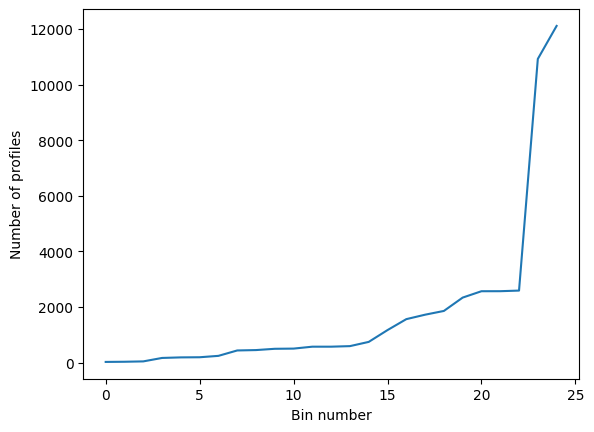

In [7]:
# plot the g_len_sorted
import matplotlib.pyplot as plt
plt.plot(g_len_sorted)
# add labels
plt.xlabel('Bin number')
plt.ylabel('Number of profiles')
plt.show()

In [18]:
print(np.mean(g_len))

313.0065359477124


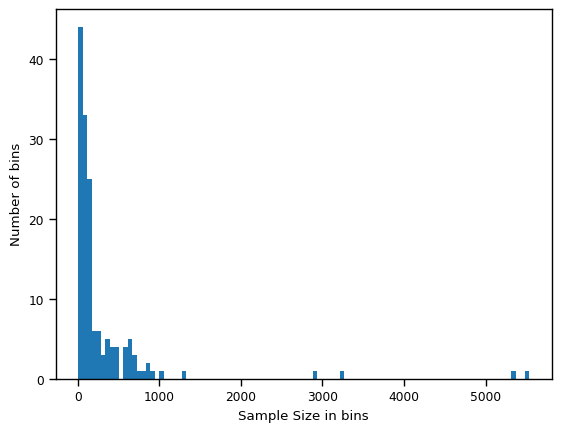

In [35]:
import matplotlib.pyplot as plt

plt.hist(g_len, bins=100)

# Add axis labels and a title
plt.xlabel("Sample Size in bins")
plt.ylabel("Number of bins")

# Show the plot
plt.show()


In [6]:
import pandas as pd

# Convert the 'lat' and 'lon' variables into a pandas dataframe
df_latlon = ds_cleaned[['lat', 'lon']].to_dataframe()

lat_size = 5.0
lon_size =5.0

lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,180, lon_size))
lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,90, lat_size))

latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

for group_key in latlon_groups.groups:
    group = latlon_groups.get_group(group_key)
    print(f"Group {group_key}: {len(group)} rows")


Group (Interval(-180.0, -175.0, closed='right'), Interval(75.0, 80.0, closed='right')): 58 rows
Group (Interval(-180.0, -175.0, closed='right'), Interval(80.0, 85.0, closed='right')): 99 rows


KeyError: (Interval(-180.0, -175.0, closed='right'), nan)

In [50]:
latlon_groups.groups

{((-180.0, -175.0], (75.0, 80.0]): [9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9905, 9906, 9907, 9908, 9911, 9912, 9913, 9914, 9915], ((-180.0, -175.0], (80.0, 85.0]): [17593, 17594, 17595, 17596, 17597, 17598, 17599, 17600, 17601, 17602, 17603, 17604, 17605, 17606, 17607, 17608, 17609, 17610, 17611, 17612, 17613, 17614, 17615, 17616, 17617, 17618, 17619, 17620, 17621, 17622, 17623, 17624, 17625, 17626, 17627, 17628, 17629, 17630, 17631, 17632, 17633, 17634, 17635, 17636, 17637, 17638, 17639, 17651, 17828, 17829, 17830, 17831, 17832, 17833, 17834, 17835, 17836, 17837, 17838, 17839, 17840, 17841, 17842, 17843, 17844, 17845, 17846, 17847, 17848, 45589, 45590, 45591, 45592, 45593, 45594, 45595, 45596, 45597, 45598, 45599, 45600, 45601, 45602,

In [29]:
import pandas as pd

# Convert the 'lat' and 'lon' variables into a pandas dataframe
df_latlon = ds_cleaned[['lat', 'lon']].to_dataframe()

lat_size = 5.0
lon_size =5.0

lon_bins = pd.cut(df_latlon['lon'], bins=np.arange(-180,180, lon_size))
lat_bins = pd.cut(df_latlon['lat'], bins=np.arange(-90,90, lat_size))

latlon_groups = df_latlon.groupby([lon_bins, lat_bins])

group = latlon_groups.get_group((pd.Interval(-180, -175,closed='right'), pd.Interval(75, 80,closed='right')))
len(group.index)


In [35]:
df_latlon

lat       lon  profiler                       date
nprof                                                        
0      80.0378 -149.1544       100 2017-09-20 00:02:04.416000
1      80.0992 -148.7704       100 2017-09-21 00:02:02.688000
2      80.1768 -147.9601       100 2017-09-22 00:02:02.688000
3      80.2801 -145.6491       100 2017-09-24 00:02:02.688000
4      80.3072 -145.0618       100 2017-09-25 00:02:02.688000
...        ...       ...       ...                        ...
47885  82.6869  -97.2736         9 2008-12-05 00:24:14.976000
47886  82.6647  -97.3694         9 2008-12-05 07:12:00.864000
47887  82.6484  -97.4092         9 2008-12-05 12:00:05.183999
47888  82.7462  -95.5062         9 2009-01-15 00:24:18.432000
47889  82.7572  -95.2933         9 2009-01-15 07:12:01.728000

[47890 rows x 4 columns]

In [31]:

unique_groups = latlon_groups.groups.keys()
print(unique_groups)


dict_keys([(Interval(-180.0, -175.0, closed='right'), Interval(75.0, 80.0, closed='right')), (Interval(-180.0, -175.0, closed='right'), Interval(80.0, 85.0, closed='right')), (Interval(-180.0, -175.0, closed='right'), nan), (Interval(-175.0, -170.0, closed='right'), Interval(75.0, 80.0, closed='right')), (Interval(-175.0, -170.0, closed='right'), Interval(80.0, 85.0, closed='right')), (Interval(-175.0, -170.0, closed='right'), nan), (Interval(-170.0, -165.0, closed='right'), Interval(80.0, 85.0, closed='right')), (Interval(-170.0, -165.0, closed='right'), nan), (Interval(-165.0, -160.0, closed='right'), Interval(70.0, 75.0, closed='right')), (Interval(-165.0, -160.0, closed='right'), Interval(75.0, 80.0, closed='right')), (Interval(-165.0, -160.0, closed='right'), Interval(80.0, 85.0, closed='right')), (Interval(-165.0, -160.0, closed='right'), nan), (Interval(-160.0, -155.0, closed='right'), Interval(70.0, 75.0, closed='right')), (Interval(-160.0, -155.0, closed='right'), Interval(75.

In [33]:
group = latlon_groups.get_group((pd.Interval(-180, -175,closed='right'), pd.Interval(75, 80,closed='right')))



In [46]:
group.index.values


array([9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861,
       9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870, 9871, 9872,
       9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881, 9882, 9883,
       9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894,
       9895, 9896, 9897, 9898, 9899, 9905, 9906, 9907, 9908, 9911, 9912,
       9913, 9914, 9915], dtype=int64)

In [48]:
len(group.index)

58

In [52]:
# Patitioning the data into training and testing dataset
def data_partioning(ds_cleaned, ratio=0.8):
    size=int(ds_cleaned.nprof.size*ratio)
    indices = np.random.choice(ds_cleaned.nprof, size=size, replace=False)
    ds_train = ds_cleaned.isel(nprof=indices)

    indices = np.setdiff1d(ds_cleaned.nprof, ds_train.nprof)
    ds_test = ds_cleaned.isel(nprof=indices)

    return ds_train, ds_test
# ratio=0.8 # The ratio of training dataset

# size=int(ds_cleaned.nprof.size*ratio)
# indices = np.random.choice(ds_cleaned.nprof, size=size, replace=False)
# ds_train = ds_cleaned.isel(nprof=indices)

# indices = np.setdiff1d(ds_cleaned.nprof, ds_train.nprof)
# ds_test = ds_cleaned.isel(nprof=indices)

In [ ]:
pstart=np.max(ds_train.pressure)
pend=np.min(ds_train.pressure)
z = np.arange(pstart,pend,-10.)
pcm_features = {'temperature': z, 'salinity':z}
m = pcm(K=3, features=pcm_features,maxvar=3)
features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}
m.fit(ds_train,features=features_in_ds,dim='pressure')

In [17]:
ds_train

<xarray.Dataset>
Dimensions:      (nprof: 38312, pressure: 99)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 ...
    salinity     (nprof, pressure) float64 ...

In [18]:
ds_test

<xarray.Dataset>
Dimensions:      (nprof: 9578, pressure: 99)
Coordinates:
    profiler     (nprof) int32 ...
    date         (nprof) datetime64[ns] ...
    lon          (nprof) float64 ...
    lat          (nprof) float64 ...
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
Dimensions without coordinates: nprof
Data variables:
    temperature  (nprof, pressure) float64 ...
    salinity     (nprof, pressure) float64 ...

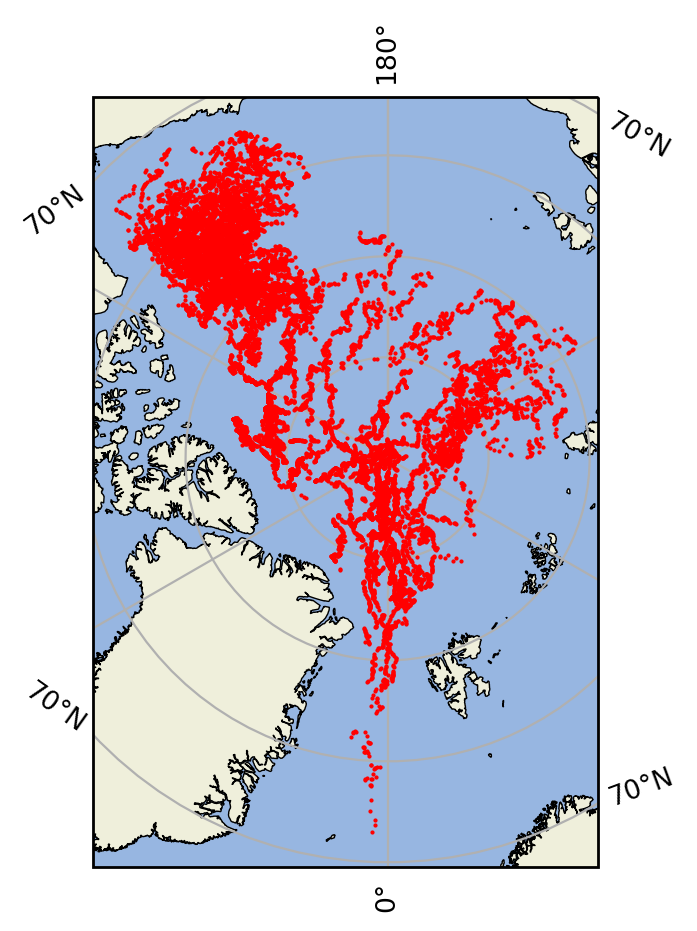

In [9]:
tb.plot_data_location(ds_train)

In [19]:
pstart=np.max(ds_train.pressure)
pend=np.min(ds_train.pressure)
z = np.arange(pstart,pend,-10.)
pcm_features = {'temperature': z, 'salinity':z}
m = pcm(K=3, features=pcm_features,maxvar=3)
m

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

In [20]:
features_in_ds = {'temperature': 'temperature', 'salinity': 'salinity'}
m.fit(ds_train,features=features_in_ds,dim='pressure')

<pcm 'gmm' (K: 3, F: 2)>
Number of class: 3
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -1.176652

In [21]:
ds_test=m.predict(ds_test,features=features_in_ds,dim='pressure',inplace=True)

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


In [22]:
ds_test

<xarray.Dataset>
Dimensions:      (nprof: 9578, pressure: 99)
Coordinates:
    profiler     (nprof) int32 78 78 78 78 78 78 78 78 78 ... 9 9 9 9 9 9 9 9 9
    date         (nprof) datetime64[ns] 2014-04-09T21:02:06.144000 ... 2009-0...
    lon          (nprof) float64 -137.1 -137.2 -137.3 ... -97.41 -95.51 -95.29
    lat          (nprof) float64 74.29 74.29 74.35 74.35 ... 82.65 82.75 82.76
  * pressure     (pressure) float64 -10.0 -15.0 -20.0 ... -490.0 -495.0 -500.0
  * nprof        (nprof) int64 0 1 2 3 4 5 6 ... 9572 9573 9574 9575 9576 9577
Data variables:
    temperature  (nprof, pressure) float64 -1.567 -1.566 -1.566 ... 0.422 0.4203
    salinity     (nprof, pressure) float64 28.88 28.88 28.88 ... 34.84 34.84
    PCM_LABELS   (nprof) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1

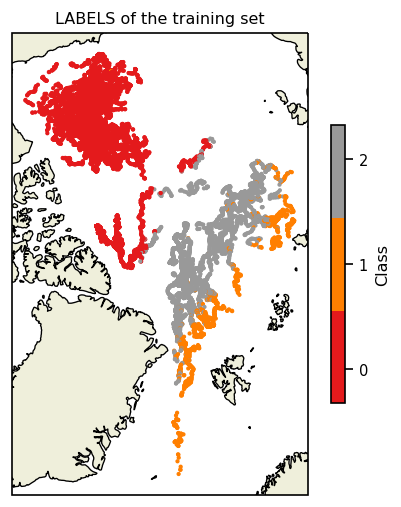

In [14]:
tb.plot_pred_map(ds_test,m)

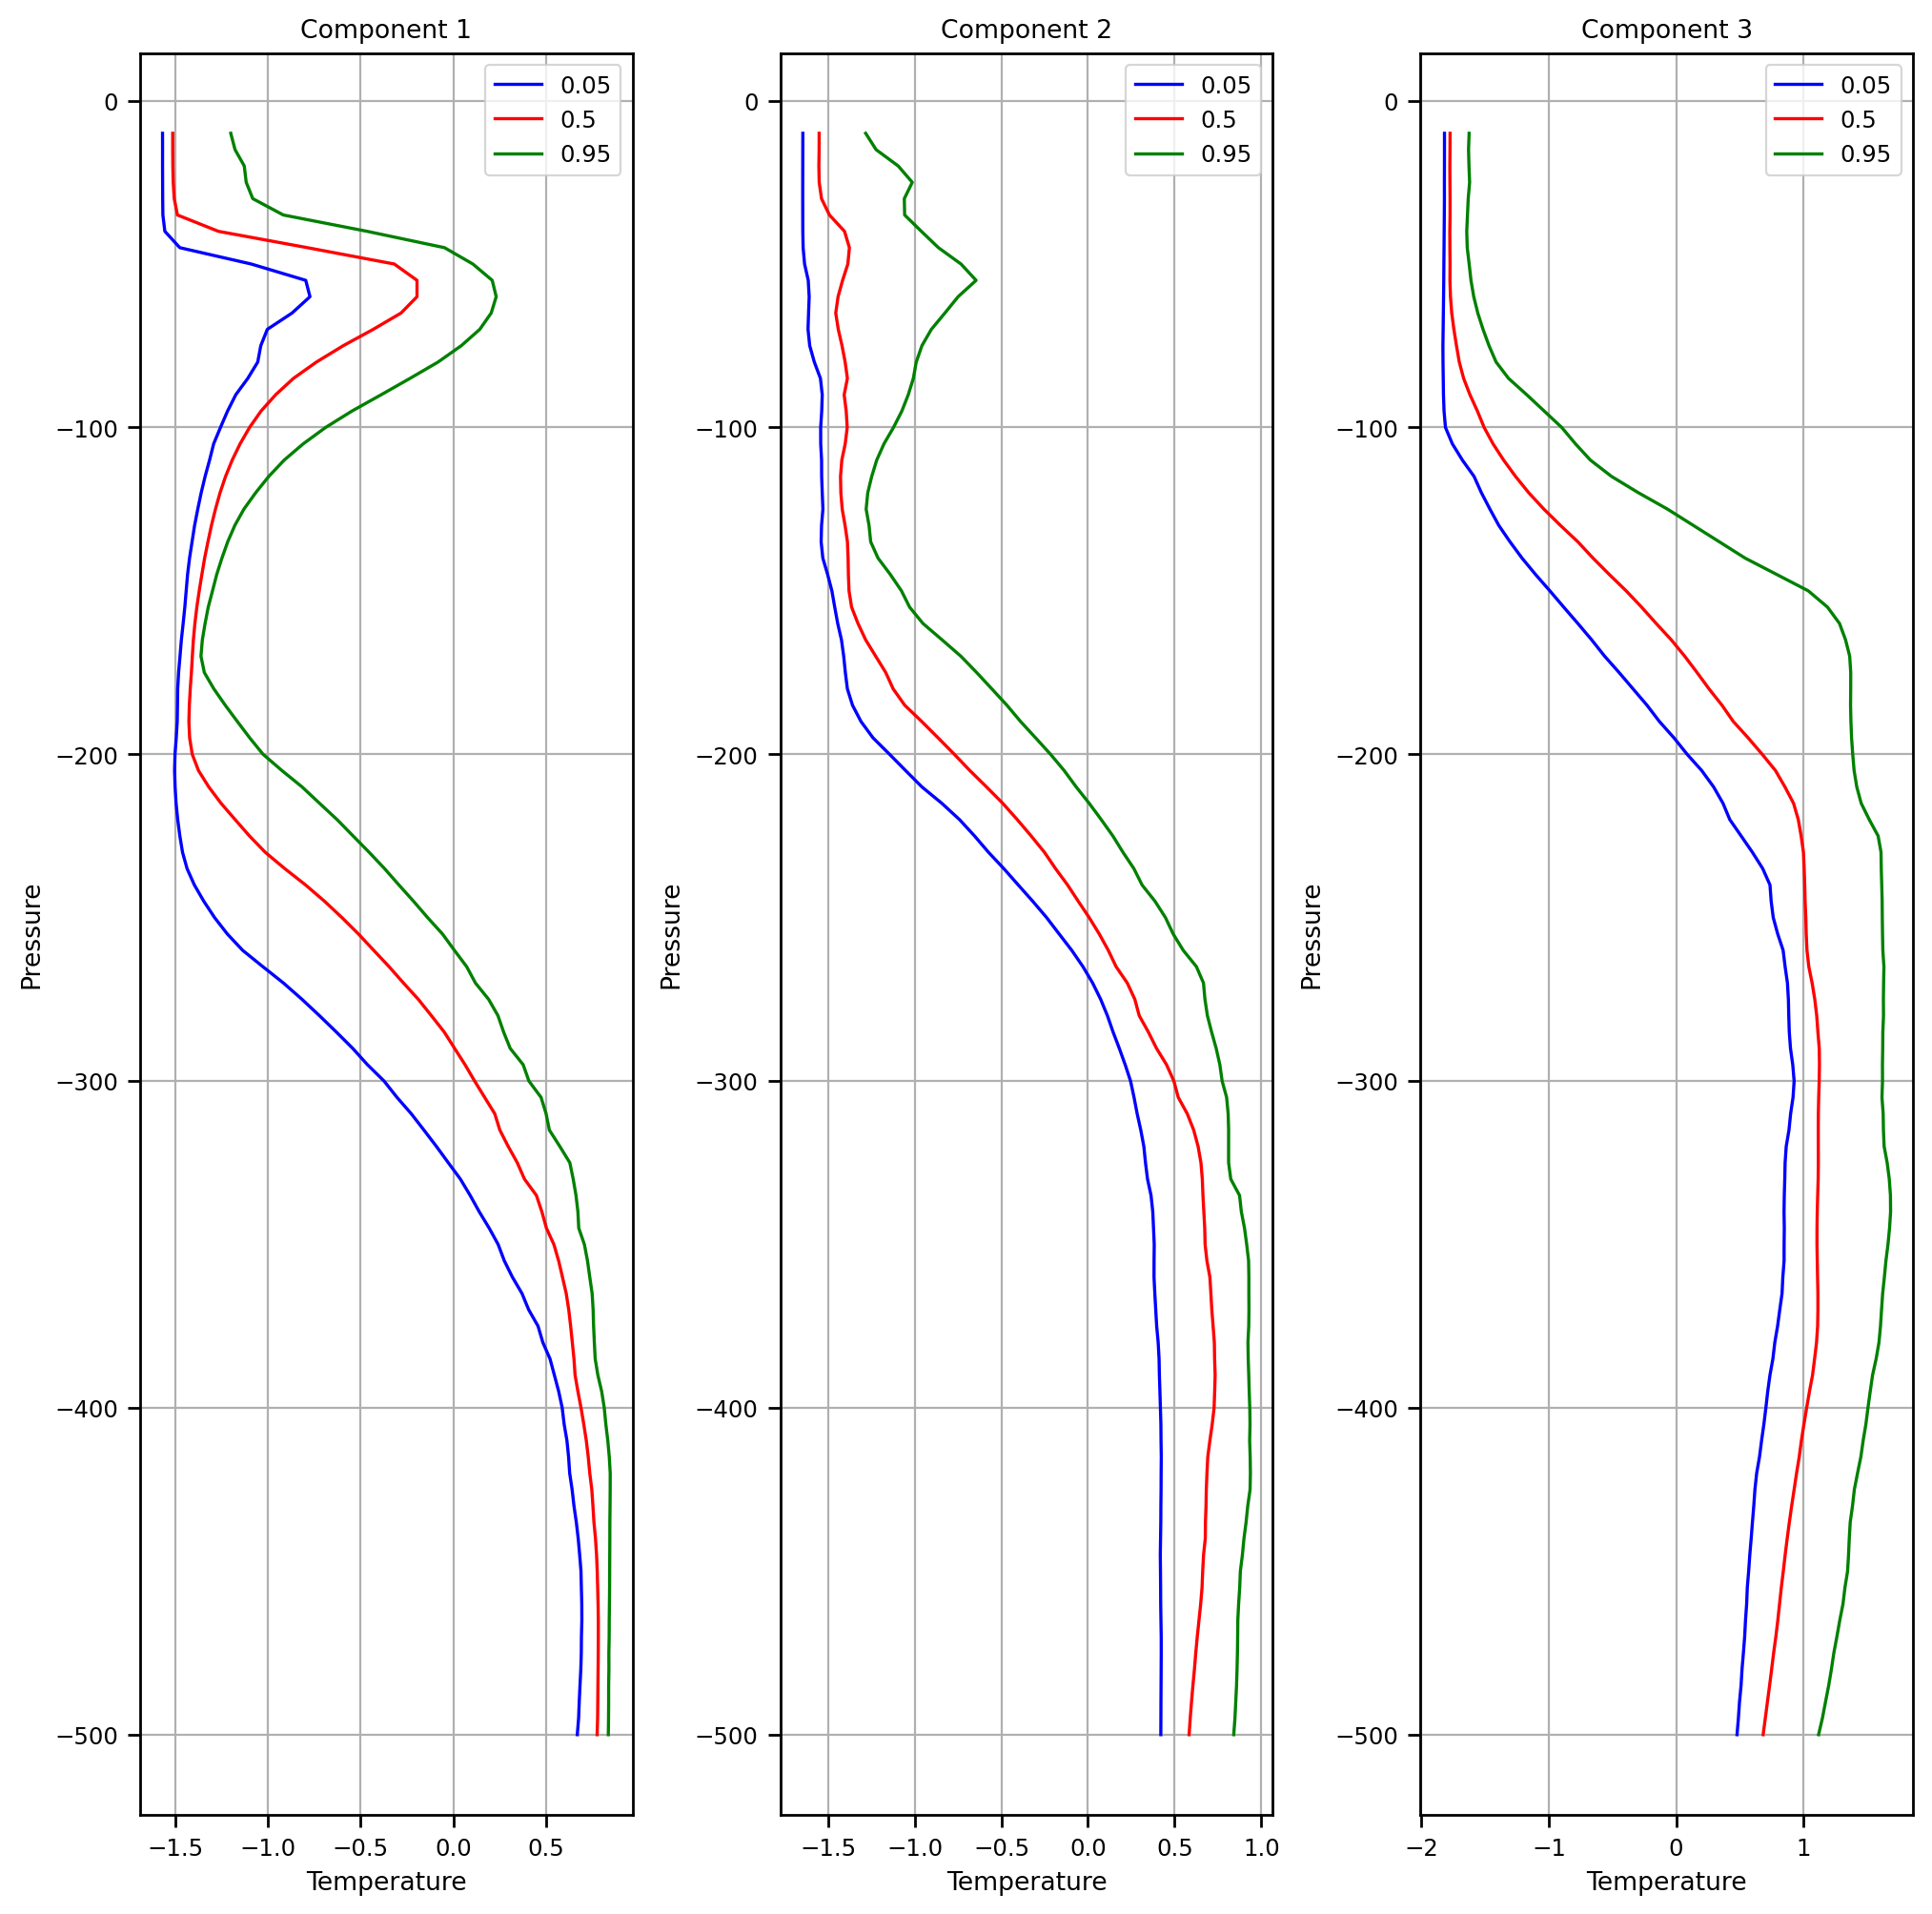

In [23]:
# Calculate the quantile and plot it
for vname in ['temperature', 'salinity']:
    ds_test = ds_test.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)    

ds_group = ds_test.groupby('PCM_LABELS')
tb.plot_quantile(ds_group)